# this notebook is to show how the use the modified scanpy ingest function 'ingest_verbose'
* it follows the scanpy tutorial on using the standard ingest function 
* https://github.com/scverse/scanpy-tutorials/blob/master/integrating-data-using-ingest.ipynb

### run the cell below and then the ingest_verbose can be called with
* ANsc.tl.ingest_verbose(adata, adata_ref, obs=['adata_ref_obs1', 'adata_ref_obs2'])


In [3]:

repo_parent_dir='../../'

import sys
if repo_parent_dir not in sys.path:
    sys.path.append(repo_parent_dir)

# import the package
import adata_and_scanpy_tools as adsctl
# import the preprocessing class module
from adata_and_scanpy_tools.adsctl_gex_class import *


In [4]:
#### now lets check the doc string for the ANsc.tl.injest_verbose function

print(adsctl.tl.ingest_verbose.__doc__)

    hello i modified this ingest

     * more than just a single obs column (e.g. adata_ref_obs1) is added to the adata_query.obs for each key specified in obs argument
    * standard ingests normally adds a cell labels column to the adata_query.obs for each key specified in obs argument
    * in this case there was only a single obs key passed so standard ingest would have just added adata.obs['louvain']
    * these are the addtional columns that ingest_verbose adds
    * 'KNN_distances', #### this is all of the distances from the query cell to the KNN network in the adata_ref reference cells
    * 'KNN_avg_distance', #### this is the average distance from the query cell to the KNN network in the adata_ref reference cells
    * 'KNN_std_distance',  #### this is the standard deviation of the distances from the query cell to the KNN network in the adata_ref reference cells
    * 'adata_ref_obs1_all_KNN', ### this the cell labels for all of the KNN group
    * adata_ref_obs1_KNN_pct_most

* # Integrating data using ingest_verbose and BBKNN

The following tutorial describes a simple PCA-based method for integrating data we call [ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) and compares it with [BBKNN](https://github.com/Teichlab/bbknn) [[Polanski19]](https://doi.org/10.1093/bioinformatics/btz625). BBKNN integrates well with the Scanpy workflow and is accessible through the [bbknn](https://scanpy.readthedocs.io/en/stable/external/scanpy.external.pp.bbknn.html) function.
    
The [ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) function assumes an annotated reference dataset that captures the biological variability of interest. The rational is to fit a model on the reference data and use it to project new data. For the time being, this model is a PCA combined with a neighbor lookup search tree, for which we use UMAP's implementation [[McInnes18]](https://arxiv.org/abs/1802.03426). Similar PCA-based integrations have been used before, for instance, in [[Weinreb18]](https://doi.org/10.1101/467886).

* As [ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) is simple and the procedure clear, the workflow is transparent and fast.
* Like BBKNN, [ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) leaves the data matrix itself invariant.
* Unlike BBKNN, [ingest](https://scanpy.readthedocs.io/en/latest/api/scanpy.tl.ingest.html) solves the label mapping problem (like scmap) and maintains an embedding that might have desired properties like specific clusters or trajectories.

We refer to this *asymmetric* dataset integration as *ingesting* annotations from an annotated reference `adata_ref` into an `adata` that still lacks this annotation. It is different from learning a joint representation that integrates datasets in a symmetric way as [BBKNN](https://github.com/Teichlab/bbknn), Scanorma, Conos, CCA (e.g. in Seurat) or a conditional VAE (e.g. in scVI, trVAE) would do, but comparable to the initiall MNN implementation in scran. Take a look at tools in the [external API](https://scanpy.readthedocs.io/en/latest/external/#data-integration) or at the [ecoystem page](https://scanpy.readthedocs.io/en/latest/ecosystem/#data-integration) to get a start with other tools.

# Download data and load modules / paths 

In [5]:

repo_parent_dir='../../'

import sys
if repo_parent_dir not in sys.path:
    sys.path.append(repo_parent_dir)

# import the package
import adata_and_scanpy_tools as adsctl
# import the preprocessing class module
#from adata_and_scanpy_tools.adsctl_gex_class import *

import os
import sys
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

In [6]:
import scanpy as sc
import pandas as pd
import seaborn as sns
sc.settings.verbosity = 1             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(3, 3), facecolor='white')

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.4.0
adata_and_scanpy_tools      NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
cffi                        1.15.1
cloudpickle                 2.2.1
colorama                    0.4.6
comm                        0.1.2
cupy                        11.5.0
cupy_backends               NA
cupyx                       NA
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.0
dask                        2022.11.1
dateutil                    2.8.2
debugpy                     1.6.6
decorator                   5.1.1
entrypoints                 0.4
executing                   1.2.0
fastrlock                   0.8
fsspec                      2023.1.0
google                      NA
h5py                        3.8.0
hypergeom_ufunc             NA
igraph                      0.10.3
invgauss_ufunc     

# PBMCs

We consider an annotated reference dataset `adata_ref` and a dataset for which you want to query labels and embeddings `adata`.

In [7]:
adata_ref = sc.datasets.pbmc3k_processed()  # this is an earlier version of the dataset from the pbmc3k tutorial
adata = sc.datasets.pbmc68k_reduced()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [8]:
adata_ref

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [9]:
adata

AnnData object with n_obs × n_vars = 700 × 765
    obs: 'bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score', 'G2M_score', 'phase', 'louvain'
    var: 'n_counts', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    uns: 'bulk_labels_colors', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

To use `sc.tl.ingest`, the datasets need to be defined on the same variables.

In [10]:
var_names = adata_ref.var_names.intersection(adata.var_names)
adata_ref = adata_ref[:, var_names]
adata = adata[:, var_names]

The model and graph (here PCA, neighbors, UMAP) trained on the reference data will explain the biological variation observed within it.

In [11]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

The manifold still looks essentially the same as in the [clustering tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html).

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


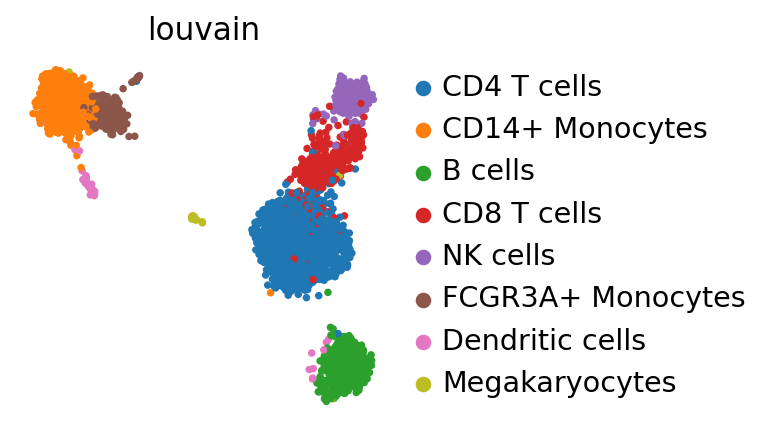

In [12]:
sc.pl.umap(adata_ref, color='louvain')

## Mapping PBMCs using ingest_verbose

Let's map labels and embeddings from `adata_ref` to `adata` based on a chosen representation. Here, we use `adata_ref.obsm['X_pca']` to map cluster labels and the UMAP coordinates.

In [13]:
adsctl.tl.ingest_verbose(adata, adata_ref, obs='louvain')

In [14]:
adata.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix colors

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


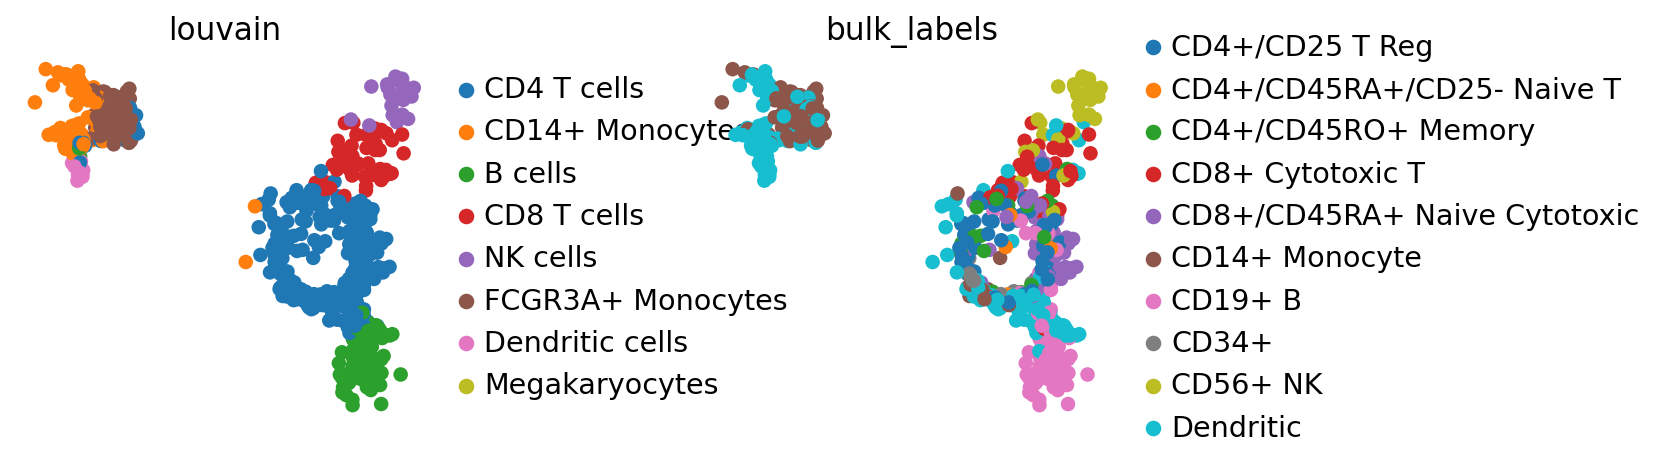

In [15]:
sc.pl.umap(adata, color=['louvain', 'bulk_labels'], wspace=0.5)

By comparing the 'bulk_labels' annotation with 'louvain', we see that the data has been reasonably mapped, only the annotation of dendritic cells seems ambiguous and might have been ambiiguous in `adata` already.

## Now lets check out the extra information that is added to the adata.obs dataframe. my the ingest_verbose function 

#### there is more information stored in the adata.obs
#### more than just a single obs column (e.g. louvain) is added to the adata.obs


 * more than just a single obs column (e.g. louvain) is added to the adata_query.obs for each key specified in obs argument
* standard ingests normally adds a cell labels column to the adata_query.obs for each key specified in obs argument
* in this case there was only a single obs key passed so standard ingest would have just added adata.obs['louvain']
* these are the addtional columns that ingest_verbose adds
* 'KNN_distances', #### this is all of the distances from the query cell to the KNN network in the adata_ref reference cells
* 'KNN_avg_distance', #### this is the average distance from the query cell to the KNN network in the adata_ref reference cells
* 'KNN_std_distance',  #### this is the standard deviation of the distances from the query cell to the KNN network in the adata_ref reference cells
* 'louvain_all_KNN', ### this the cell labels for all of the KNN group
* louvain_KNN_pct_most_common' #### frequency of the most common category label in each cells  KNN group is 
* 'louvain_KNN_pct', ##### the pct of each category label in each cell's KNN group is 
* the category corresponding to each pct is stored adata_query.uns['louvain_KNN_pct_cat_labels']
     these are in the same order as the adata.obs['louvain_KNN_pct']  values



In [16]:
# standard ingests normally would only add 'louvain',
### these are the added columns that ingests_verbose adds:
# 'KNN_distances', 'KNN_avg_distance','KNN_std_distance', 
#'louvain_all_KNN', 'louvain_KNN_pct',  louvain_KNN_pct_most_common'
adata.obs.columns

Index(['bulk_labels', 'n_genes', 'percent_mito', 'n_counts', 'S_score',
       'G2M_score', 'phase', 'louvain', 'KNN_distances', 'KNN_avg_distance',
       'KNN_std_distance', 'louvain_all_KNN', 'louvain_KNN_pct',
       'louvain_KNN_pct_most_common'],
      dtype='object')

In [17]:
adata.obs.head(1)

bulk_labels  n_genes  percent_mito  n_counts  S_score  \
index                                                                        
AAAGCCTGGCTAAC-1  CD14+ Monocyte     1003      0.023856    2557.0 -0.11916   

                  G2M_score phase            louvain  \
index                                                  
AAAGCCTGGCTAAC-1  -0.816889    G1  FCGR3A+ Monocytes   

                                                      KNN_distances  \
index                                                                 
AAAGCCTGGCTAAC-1  [7.100043296813965, 7.101424217224121, 7.10520...   

                  KNN_avg_distance  KNN_std_distance  \
index                                                  
AAAGCCTGGCTAAC-1          7.671768          0.368567   

                                                    louvain_all_KNN  \
index                                                                 
AAAGCCTGGCTAAC-1  [FCGR3A+ Monocytes, FCGR3A+ Monocytes, CD14+ M...   

                                           louvain_KNN_pct  \
index                                                        
AAAGCCTGGCTAAC-1  [0.0, 0.4, 0.0, 0.0, 0.0, 0.6, 0.0, 0.0]   

                  louvain_KNN_pct_most_common  
index                                          
AAAGCCTGGCTAAC-1                          0.6

#### lets check cell row 90


In [18]:
cell_row=90
#### this is lousvain cell label mapped to adata from adat_ref
print(adata.obs['louvain'][cell_row])
#### this is all of the distances from the query cell to the KNN network in the adata_ref reference cells
print(adata.obs['KNN_distances'][cell_row])
#### this is the average distance from the query cell to the KNN network in the adata_ref reference cells
print(adata.obs['KNN_avg_distance'][cell_row])
#### this is the standard deviation of the distances from the query cell to the KNN network in the adata_ref reference cells
print(adata.obs['KNN_std_distance'][cell_row])

NK cells
[9.280865669250488, 9.748787879943848, 9.759418487548828, 9.793941497802734, 9.81428050994873, 10.00133991241455, 10.024893760681152, 10.036325454711914, 10.178215026855469, 10.243745803833008, 10.304210662841797, 10.362728118896484, 10.380936622619629, 10.402626037597656, 10.427031517028809]
10.050622940063477
0.314479261636734


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


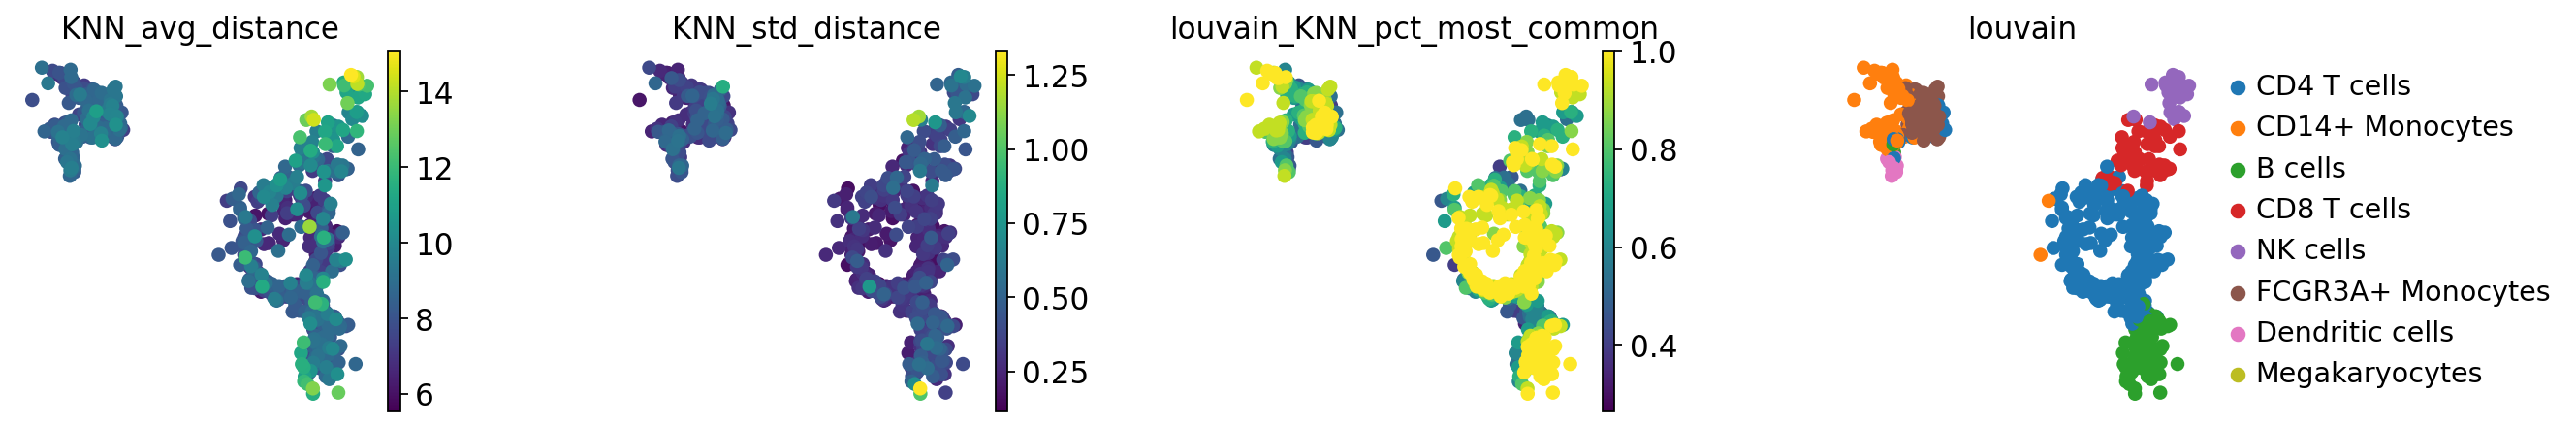

In [19]:
sc.pl.umap(adata, color=['KNN_avg_distance','KNN_std_distance','louvain_KNN_pct_most_common','louvain'
                         ], wspace=0.5)

In [20]:

#### this is the label assigned to the cell by the KNN group it is the most common
print(adata.obs['louvain'][cell_row])
### this the cell labels for all of the KNN group
print(adata.obs['louvain_all_KNN'][cell_row])
#### frequency of the most common category label in each cells  KNN group is 
print(adata.obs['louvain_KNN_pct_most_common'][cell_row])
##### the pct of each category label in each cell's KNN group is 
print(adata.obs['louvain_KNN_pct'][cell_row])
#### the category corresponding to each pct is stored adata_query.uns['louvain_KNN_pct_cat_labels']
#### these are in the same order as the adata.obs['louvain_KNN_pct']  values
print(adata.uns['louvain_KNN_pct_cat_labels'])

NK cells
['NK cells', 'CD8 T cells', 'NK cells', 'NK cells', 'NK cells', 'CD8 T cells', 'CD8 T cells', 'CD8 T cells', 'CD8 T cells', 'NK cells', 'NK cells', 'NK cells', 'CD4 T cells', 'NK cells', 'CD8 T cells']
0.5333333333333333
[0.06666666666666667, 0.0, 0.0, 0.4, 0.5333333333333333, 0.0, 0.0, 0.0]
['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells', 'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']


## now let convert the adata_ref  and adata to adata_concat

In [21]:
adata_concat = adata_ref.concatenate(adata, batch_categories=['ref', 'new'])

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


In [22]:
adata_concat.obs.louvain = adata_concat.obs.louvain.astype('category')
adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['louvain_colors'] = adata_ref.uns['louvain_colors']  # fix category colors

/tmp/ipykernel_1731556/2341824880.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.louvain.cat.reorder_categories(adata_ref.obs.louvain.cat.categories, inplace=True)  # fix category ordering


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


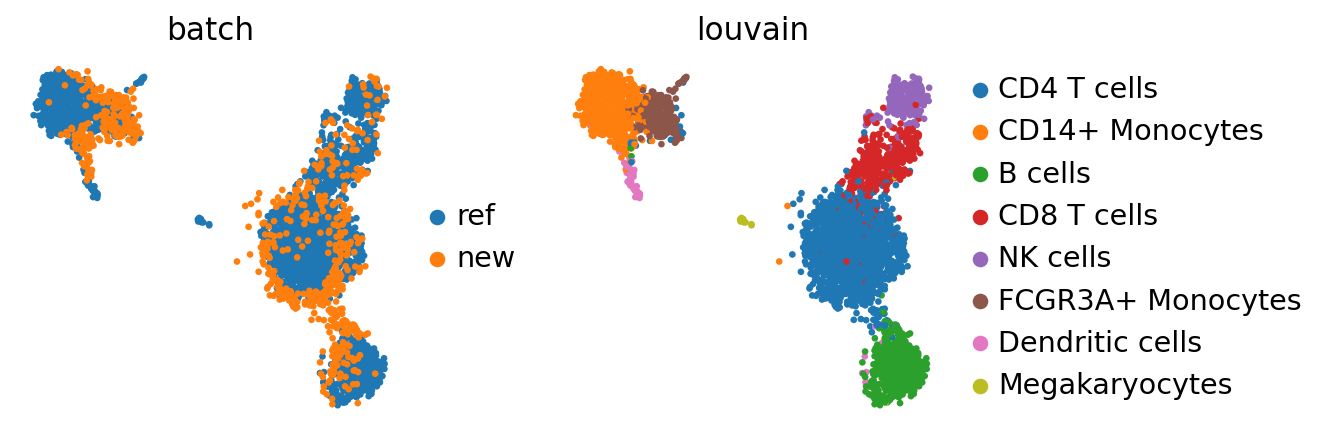

In [23]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

#### Now lets check out the extra information that is added to the adata.obs dataframe. my the ingest_verbose function 

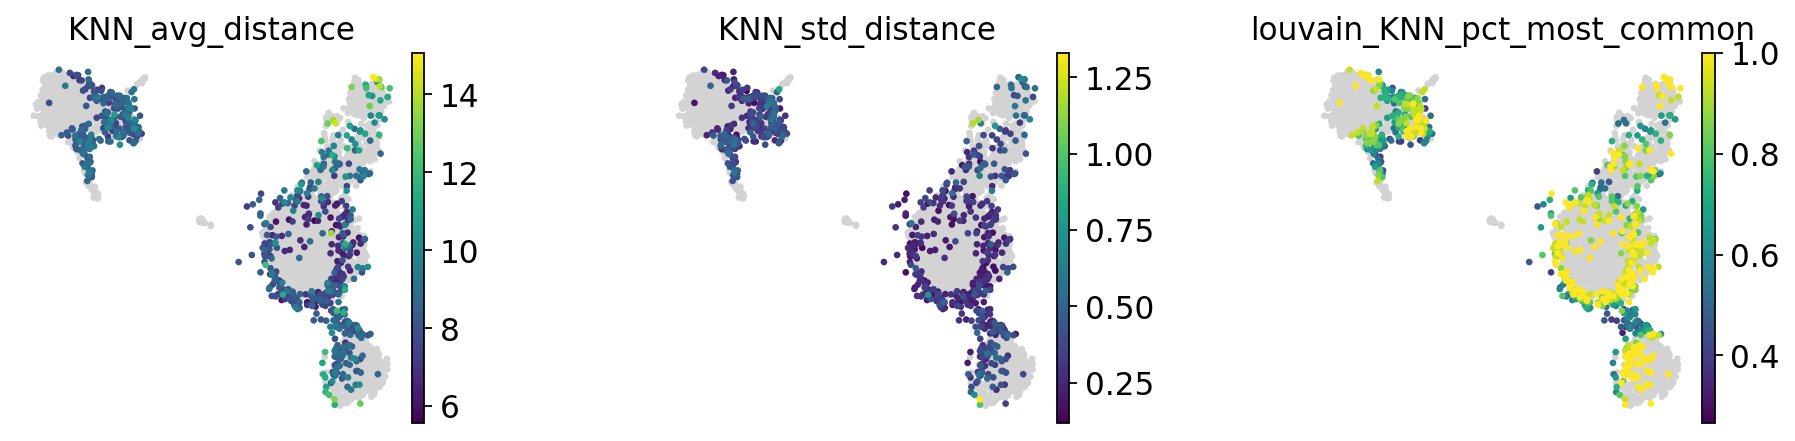

In [24]:
sc.pl.umap(adata_concat, color=['KNN_avg_distance','KNN_std_distance','louvain_KNN_pct_most_common',
                         ], wspace=0.5)

While there seems to be some batch-effect in the monocytes and dendritic cell clusters, the new data is otherwise mapped relatively homogeneously.

The megakaryoctes are only present in `adata_ref` and no cells from `adata` map onto them. If interchanging reference data and query data, Megakaryocytes do not appear as a separate cluster anymore. This is an extreme case as the reference data is very small; but one should always question if the reference data contain enough biological variation to meaningfully accomodate query data.

### Using BBKNN

In [25]:
sc.tl.pca(adata_concat)

In [26]:
%%time
sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6

CPU times: user 235 ms, sys: 5.33 ms, total: 240 ms
Wall time: 213 ms


In [27]:
sc.tl.umap(adata_concat)

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


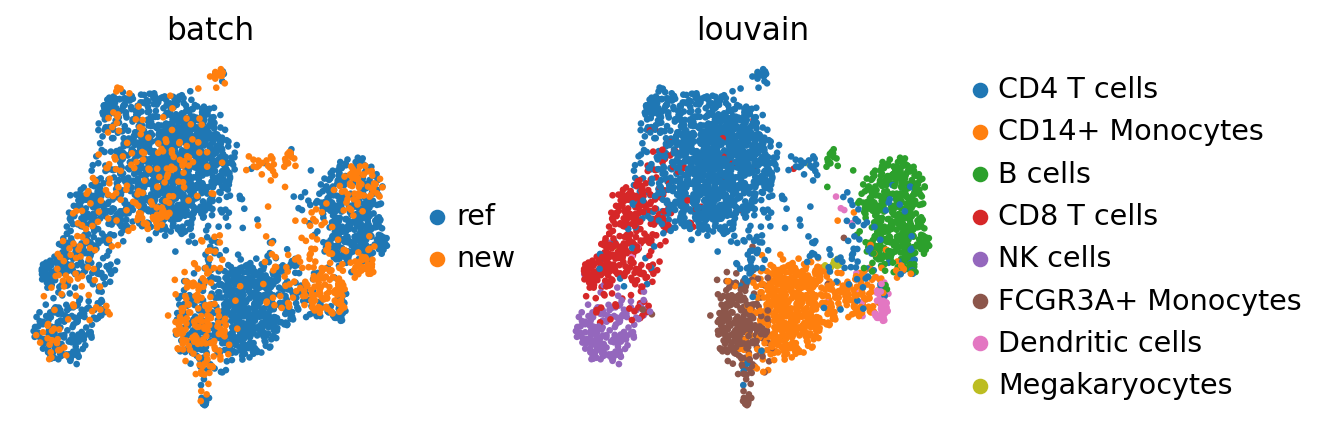

In [28]:
sc.pl.umap(adata_concat, color=['batch', 'louvain'])

Also BBKNN doesn't maintain the Megakaryocytes cluster. However, it seems to mix cells more homogeneously.

## Pancreas

The following data has been used in the scGen paper [[Lotfollahi19]](https://doi.org/10.1038/s41592-019-0494-8), has been used [here](https://nbviewer.jupyter.org/github/M0hammadL/scGen_notebooks/blob/master/notebooks/scgen_batch_removal.ipynb), was curated [here](https://nbviewer.jupyter.org/github/Teichlab/bbknn/blob/master/examples/pancreas.ipynb) and can be downloaded from [here (the BBKNN paper)](ftp://ngs.sanger.ac.uk/production/teichmann/BBKNN/objects-pancreas.zip).

It contains data for human pancreas from 4 different studies (Segerstolpe16, Baron16, Wang16, Muraro16), which have been used in the seminal papers on single-cell dataset integration (Butler18, Haghverdi18) and many times ever since.

In [29]:
# note that this collection of batches is already intersected on the genes
adata_all = sc.read('data/pancreas.h5ad', backup_url='https://www.dropbox.com/s/qj1jlm9w10wmt0u/pancreas.h5ad?dl=1')

  0%|          | 0.00/176M [00:00<?, ?B/s]

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/compat/__init__.py:232: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [30]:
adata_all.shape

(14693, 2448)

Inspect the cell types observed in these studies.

In [31]:
counts = adata_all.obs.celltype.value_counts()
counts

alpha                     4214
beta                      3354
ductal                    1804
acinar                    1368
not applicable            1154
delta                      917
gamma                      571
endothelial                289
activated_stellate         284
dropped                    178
quiescent_stellate         173
mesenchymal                 80
macrophage                  55
PSC                         54
unclassified endocrine      41
co-expression               39
mast                        32
epsilon                     28
mesenchyme                  27
schwann                     13
t_cell                       7
MHC class II                 5
unclear                      4
unclassified                 2
Name: celltype, dtype: int64

To simplify visualization, let's remove the 5 minority classes.

In [32]:
minority_classes = counts.index[-5:].tolist()        # get the minority classes
adata_all = adata_all[                               # actually subset
    ~adata_all.obs.celltype.isin(minority_classes)]
adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance 
    counts.index[:-5].tolist(), inplace=True)  

/tmp/ipykernel_1731556/2578860003.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_all.obs.celltype.cat.reorder_categories(       # reorder according to abundance


### Seeing the batch effect

In [33]:
sc.pp.pca(adata_all)
sc.pp.neighbors(adata_all)
sc.tl.umap(adata_all)

We observe a batch effect.

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


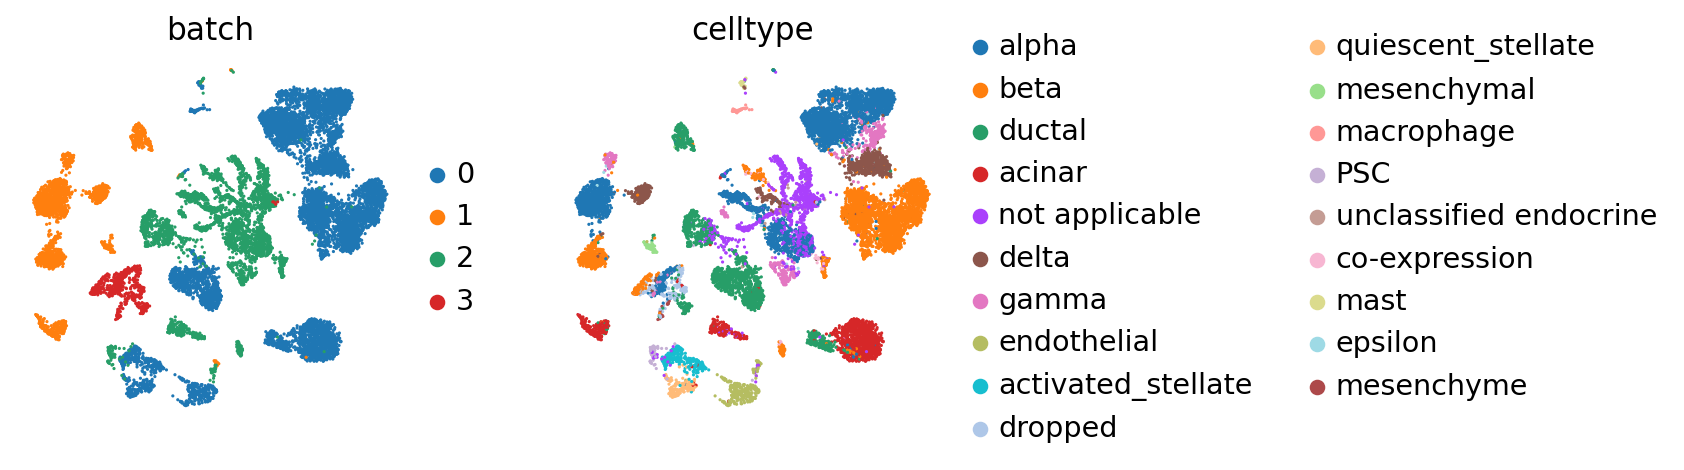

In [34]:
sc.pl.umap(adata_all, color=['batch', 'celltype'], palette=sc.pl.palettes.vega_20_scanpy)

### BBKNN

It can be well-resolved using [BBKNN](https://github.com/Teichlab/bbknn) [[Polanski19]](https://doi.org/10.1093/bioinformatics/btz625).

In [35]:
%%time
sc.external.pp.bbknn(adata_all, batch_key='batch')

CPU times: user 1.86 s, sys: 83.5 ms, total: 1.94 s
Wall time: 1.9 s


In [36]:
sc.tl.umap(adata_all)

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


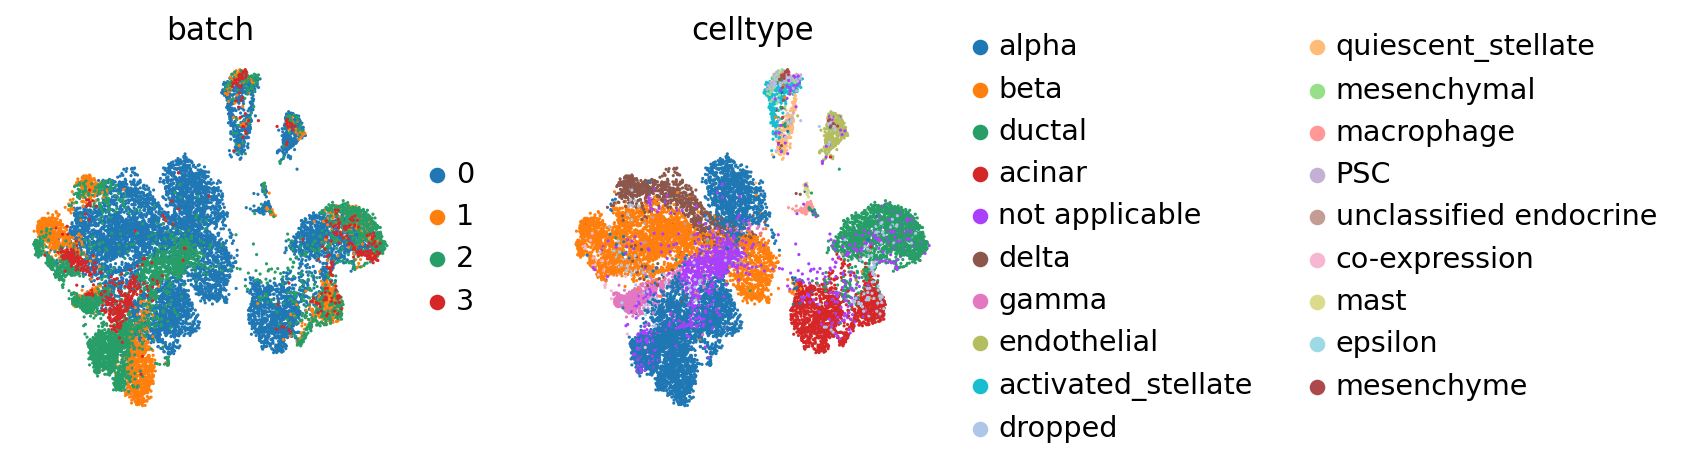

In [37]:
sc.pl.umap(adata_all, color=['batch', 'celltype'])

If one prefers to work more iteratively starting from one reference dataset, one can use ingest.

### Mapping onto a reference batch using ingest

Choose one reference batch for training the model and setting up the neighborhood graph (here, a PCA) and separate out all other batches.

As before, the model trained on the reference batch will explain the biological variation observed within it.

In [38]:
adata_ref = adata_all[adata_all.obs.batch == '0']

Compute the PCA, neighbors and UMAP on the reference data.

In [39]:
sc.pp.pca(adata_ref)
sc.pp.neighbors(adata_ref)
sc.tl.umap(adata_ref)

The reference batch contains 12 of the 19 cell types across all batches.

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


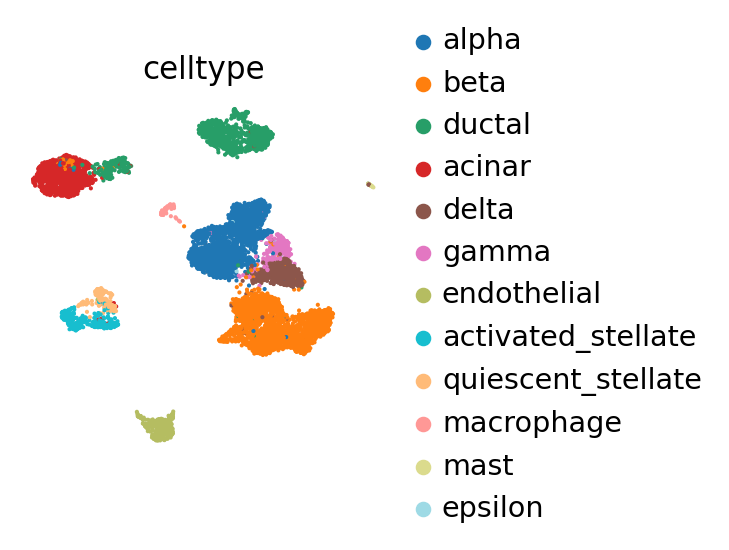

In [40]:
sc.pl.umap(adata_ref, color='celltype')

Iteratively map labels (such as 'celltype') and embeddings (such as 'X_pca' and 'X_umap') from the reference data onto the query batches.

In [41]:
adatas = [adata_all[adata_all.obs.batch == i].copy() for i in ['1', '2', '3']]

In [42]:
sc.settings.verbosity = 2  # a bit more logging
for iadata, adata in enumerate(adatas):
    print(f'... integrating batch {iadata+1}')
    adata.obs['celltype_orig'] = adata.obs.celltype  # save the original cell type
    adsctl.tl.ingest_verbose(adata, adata_ref, obs='celltype')

... integrating batch 1
running ingest
    finished (0:00:05)
... integrating batch 2
running ingest
    finished (0:00:07)
... integrating batch 3
running ingest
    finished (0:00:02)


Each of the query batches now carries annotation that has been contextualized with `adata_ref`. By concatenating, we can view it together.

In [43]:
adata_concat = adata_ref.concatenate(adatas)

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float6

In [44]:
adata_concat.obs.celltype = adata_concat.obs.celltype.astype('category')
adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering
adata_concat.uns['celltype_colors'] = adata_ref.uns['celltype_colors']  # fix category coloring

/tmp/ipykernel_1731556/1749108536.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  adata_concat.obs.celltype.cat.reorder_categories(adata_ref.obs.celltype.cat.categories, inplace=True)  # fix category ordering


/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


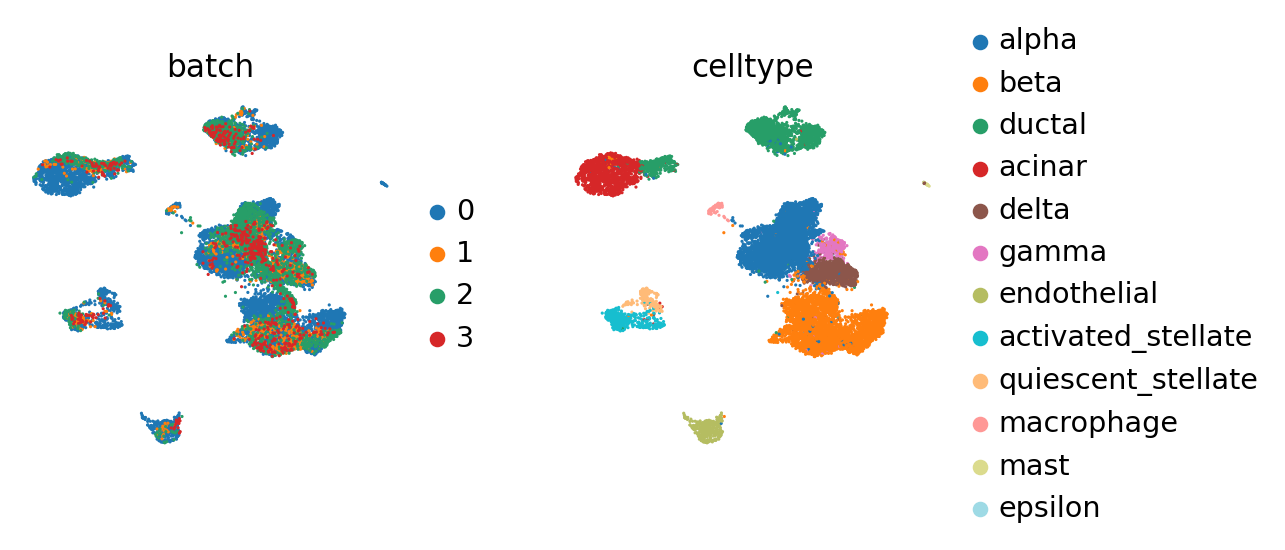

In [45]:
sc.pl.umap(adata_concat, color=['batch', 'celltype'])

#### Now lets check out the extra information that is added to the adata.obs dataframe. my the ingest_verbose function 

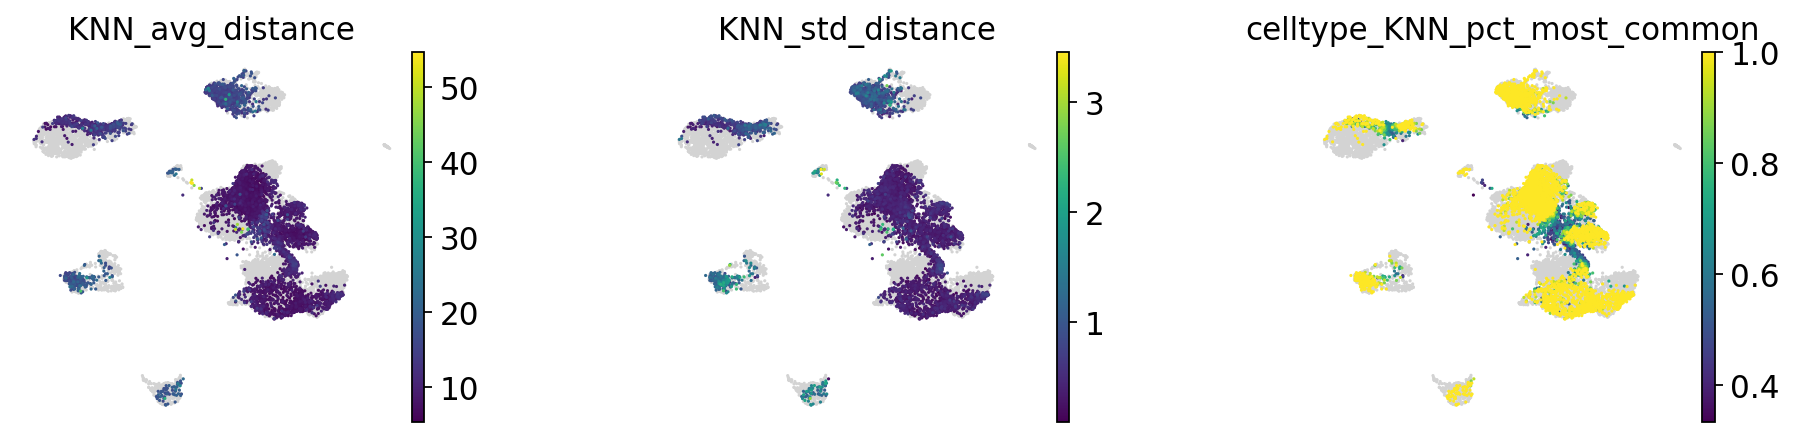

In [46]:
sc.pl.umap(adata_concat, color=['KNN_avg_distance','KNN_std_distance','celltype_KNN_pct_most_common',
                         ], wspace=0.5)

In [47]:
adata_concat.obs

celltype sample  n_genes batch      n_counts  \
index                                                                          
human1_lib1.final_cell_0001-0-0   acinar  Baron     3526     0  2.241100e+04   
human1_lib1.final_cell_0002-0-0   acinar  Baron     4201     0  2.794900e+04   
human1_lib1.final_cell_0003-0-0   acinar  Baron     2119     0  1.689200e+04   
human1_lib1.final_cell_0004-0-0   acinar  Baron     2956     0  1.929900e+04   
human1_lib1.final_cell_0005-0-0   acinar  Baron     2715     0  1.506700e+04   
...                                  ...    ...      ...   ...           ...   
reads.29499-3-3                   ductal   Wang    19950     3  1.056558e+06   
reads.29500-3-3                   ductal   Wang    19950     3  9.926309e+05   
reads.29501-3-3                     beta   Wang    19950     3  1.751338e+06   
reads.29502-3-3                   ductal   Wang    19950     3  2.163764e+06   
reads.29503-3-3                     beta   Wang    19950     3  2.038979e+06   

                                louvain celltype_orig  \
index                                                   
human1_lib1.final_cell_0001-0-0       2           NaN   
human1_lib1.final_cell_0002-0-0       2           NaN   
human1_lib1.final_cell_0003-0-0       2           NaN   
human1_lib1.final_cell_0004-0-0       2           NaN   
human1_lib1.final_cell_0005-0-0       2           NaN   
...                                 ...           ...   
reads.29499-3-3                      10        ductal   
reads.29500-3-3                      10        ductal   
reads.29501-3-3                      10          beta   
reads.29502-3-3                      10       dropped   
reads.29503-3-3                      10          beta   

                                                                     KNN_distances  \
index                                                                                
human1_lib1.final_cell_0001-0-0                                                NaN   
human1_lib1.final_cell_0002-0-0                                                NaN   
human1_lib1.final_cell_0003-0-0                                                NaN   
human1_lib1.final_cell_0004-0-0                                                NaN   
human1_lib1.final_cell_0005-0-0                                                NaN   
...                                                                            ...   
reads.29499-3-3                  [13.170419692993164, 13.823159217834473, 14.12...   
reads.29500-3-3                  [12.375604629516602, 12.634172439575195, 13.49...   
reads.29501-3-3                  [7.205275535583496, 7.296786308288574, 7.29955...   
reads.29502-3-3                  [10.042680740356445, 10.259117126464844, 10.40...   
reads.29503-3-3                  [6.8516645431518555, 7.009548664093018, 7.1654...   

                                 KNN_avg_distance  KNN_std_distance  \
index                                                                 
human1_lib1.final_cell_0001-0-0               NaN               NaN   
human1_lib1.final_cell_0002-0-0               NaN               NaN   
human1_lib1.final_cell_0003-0-0               NaN               NaN   
human1_lib1.final_cell_0004-0-0               NaN               NaN   
human1_lib1.final_cell_0005-0-0               NaN               NaN   
...                                           ...               ...   
reads.29499-3-3                         14.422451          0.446877   
reads.29500-3-3                         14.118630          0.729157   
reads.29501-3-3                          7.645518          0.205024   
reads.29502-3-3                         10.810390          0.456401   
reads.29503-3-3                          7.551676          0.309320   

                                                                  celltype_all_KNN  \
index                                                                                
human1_lib1.final_cell_0001-0-0   

Compared to the BBKNN result, this is maintained clusters in a much more pronounced fashion. If one already observed a desired continuous structure (as in the hematopoietic datasets, for instance), `ingest` allows to easily maintain this structure.

### Evaluating consistency

Let us subset the data to the query batches.

In [48]:
adata_query = adata_concat[adata_concat.obs.batch.isin(['1', '2', '3'])]

The following plot is a bit hard to read, hence, move on to confusion matrices below.

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


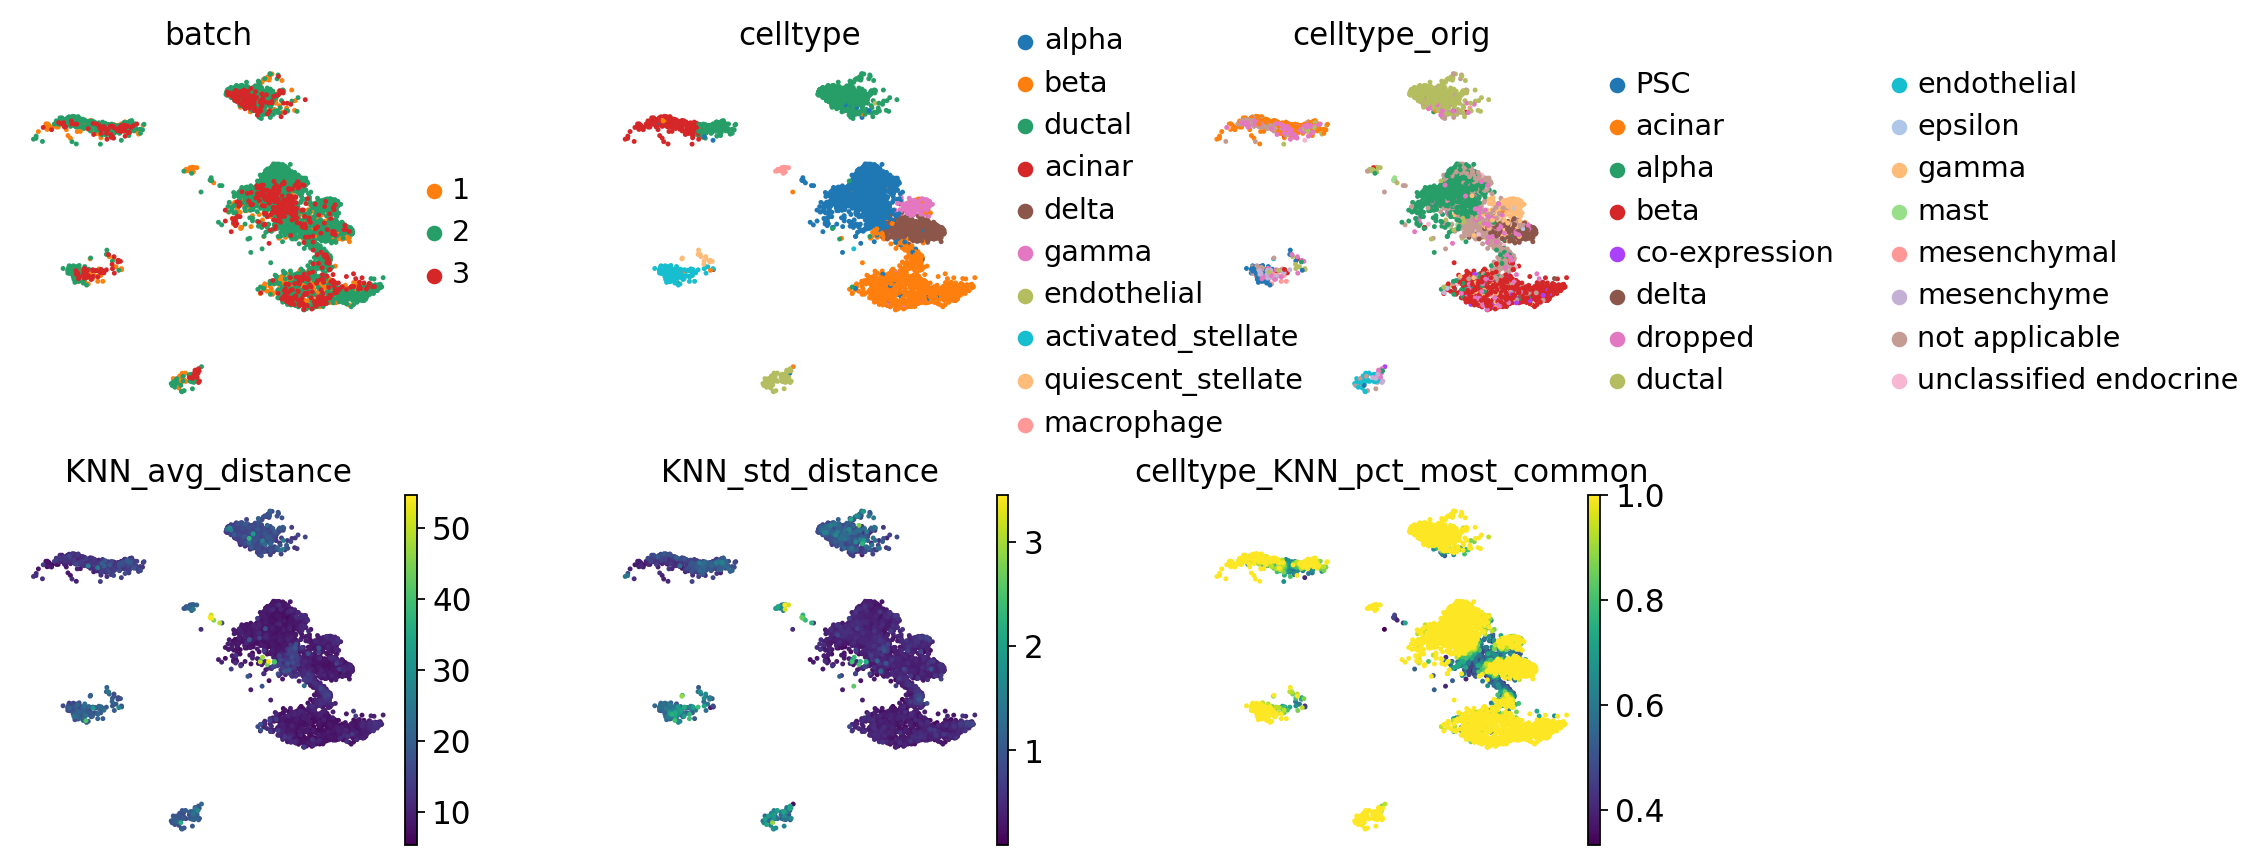

In [49]:
sc.pl.umap(
    adata_query, color=['batch', 'celltype', 'celltype_orig',
                        'KNN_avg_distance','KNN_std_distance','celltype_KNN_pct_most_common'],ncols=3,wspace=0.4)





#### Cell types conserved across batches

Let us first focus on cell types that are conserved with the reference, to simplify reading of the confusion matrix.

In [50]:
obs_query = adata_query.obs
conserved_categories = obs_query.celltype.cat.categories.intersection(obs_query.celltype_orig.cat.categories)  # intersected categories
obs_query_conserved = obs_query.loc[obs_query.celltype.isin(conserved_categories) & obs_query.celltype_orig.isin(conserved_categories)]  # intersect categories
obs_query_conserved.celltype.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
obs_query_conserved.celltype_orig.cat.reorder_categories(obs_query_conserved.celltype.cat.categories, inplace=True)  # fix category ordering

/tmp/ipykernel_1731556/2750919581.py:4: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  obs_query_conserved.celltype.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
/tmp/ipykernel_1731556/2750919581.py:5: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  obs_query_conserved.celltype_orig.cat.remove_unused_categories(inplace=True)  # remove unused categoriyes
/tmp/ipykernel_1731556/2750919581.py:6: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  obs_query_conserved.celltype_orig.cat.reorder_categories(obs_query_conserved.celltype.cat.categories, inplace=True)  # fix category ordering


In [51]:
pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_orig)

celltype_orig  alpha  beta  ductal  acinar  delta  gamma  endothelial
celltype                                                             
alpha           1814     3      12       0      1     19            0
beta              54   805       4       1     10     39            0
ductal             6     6     686     242      0      0            0
acinar             2     3       3     165      0      3            0
delta              6     3       2       0    305     73            0
gamma              1     5       0       1      0    182            0
endothelial        2     0       0       0      0      0           36

/tmp/ipykernel_1731556/95340135.py:5: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.pcolor(norm_df)


celltype_orig     alpha      beta    ductal    acinar     delta     gamma  \
celltype                                                                    
alpha          0.962334  0.003636  0.016973  0.000000  0.003165  0.060127   
beta           0.028647  0.975758  0.005658  0.002445  0.031646  0.123418   
ductal         0.003183  0.007273  0.970297  0.591687  0.000000  0.000000   
acinar         0.001061  0.003636  0.004243  0.403423  0.000000  0.009494   
delta          0.003183  0.003636  0.002829  0.000000  0.965190  0.231013   
gamma          0.000531  0.006061  0.000000  0.002445  0.000000  0.575949   
endothelial    0.001061  0.000000  0.000000  0.000000  0.000000  0.000000   

celltype_orig  endothelial  
celltype                    
alpha                  0.0  
beta                   0.0  
ductal                 0.0  
acinar                 0.0  
delta                  0.0  
gamma                  0.0  
endothelial            1.0

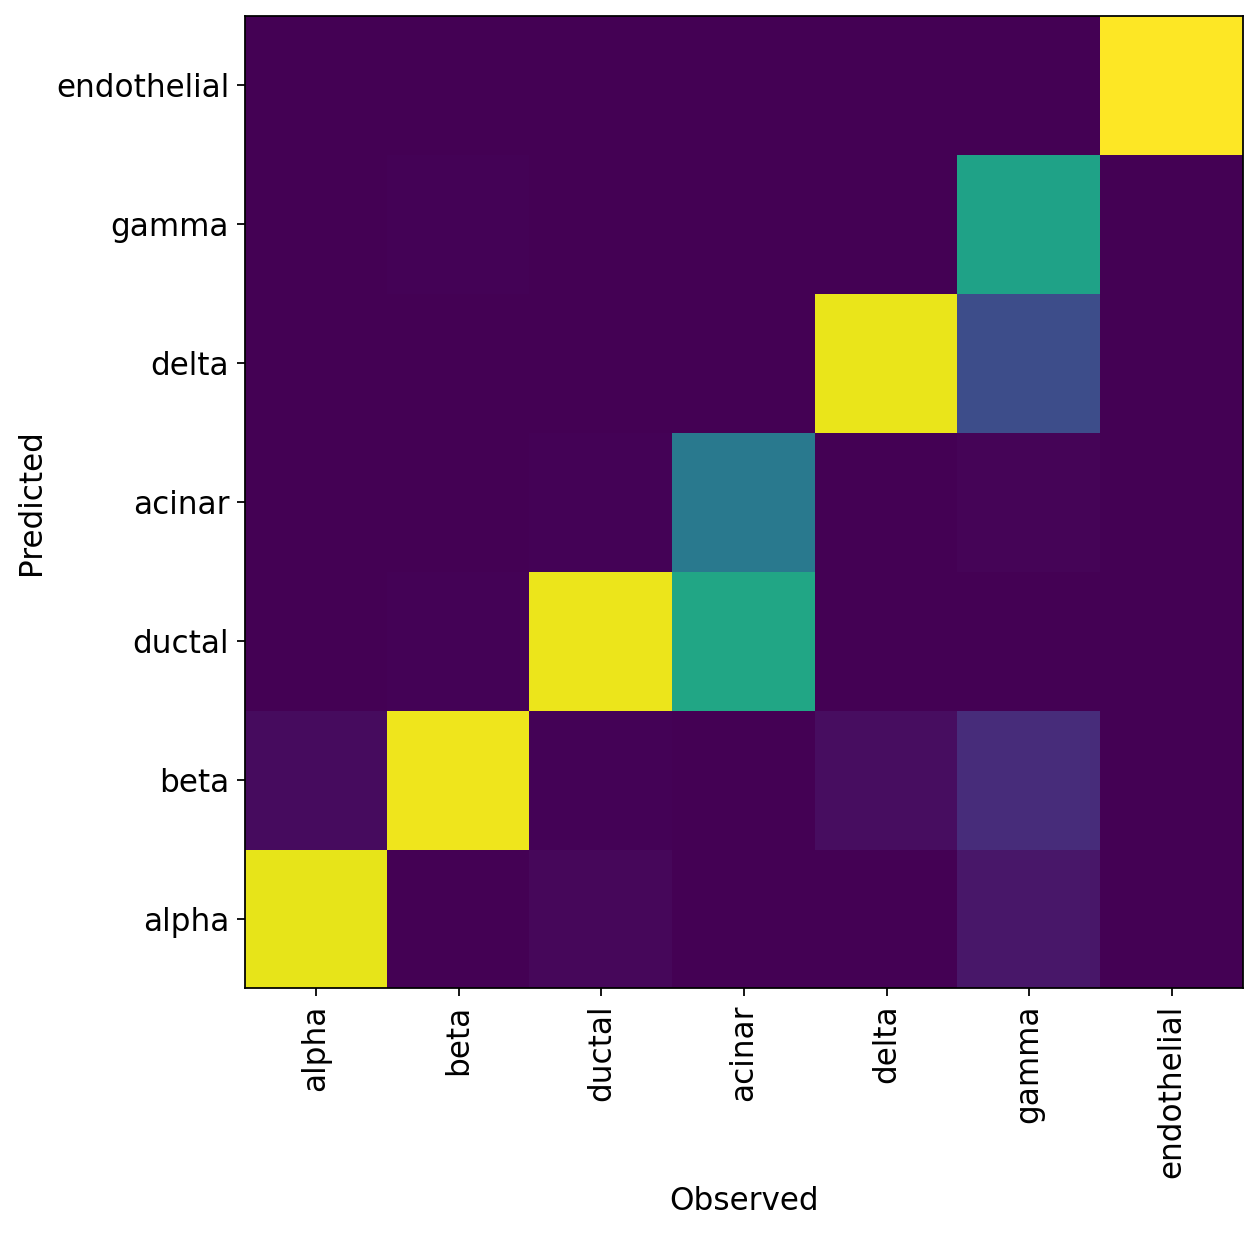

In [52]:
df=pd.crosstab(obs_query_conserved.celltype, obs_query_conserved.celltype_orig)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Observed")
plt.ylabel("Predicted")

norm_df

Overall, the conserved cell types are also mapped as expected. The main exception are some acinar cells in the original annotation that appear as acinar cells. However, already the reference data is observed to feature a cluster of both acinar and ductal cells, which explains the discrepancy, and indicates a potential inconsistency in the initial annotation.

### lets looks at the the celltype_KNN_pct_most_common for the two celltypes that were mapped least well

#### all the adata_query cells

<AxesSubplot: >

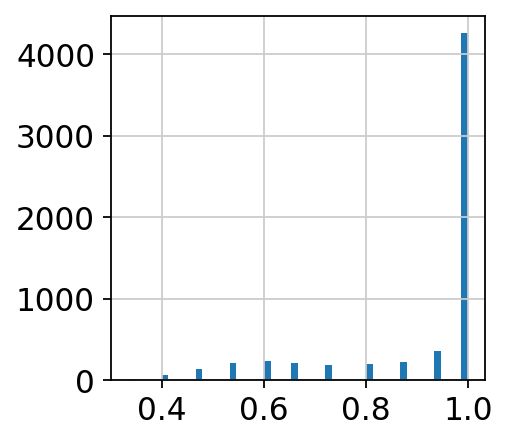

In [53]:
## here is the distribution of the  pct most common cell type for all cells in the query
adata_query.obs['celltype_KNN_pct_most_common'].hist(bins=50)

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


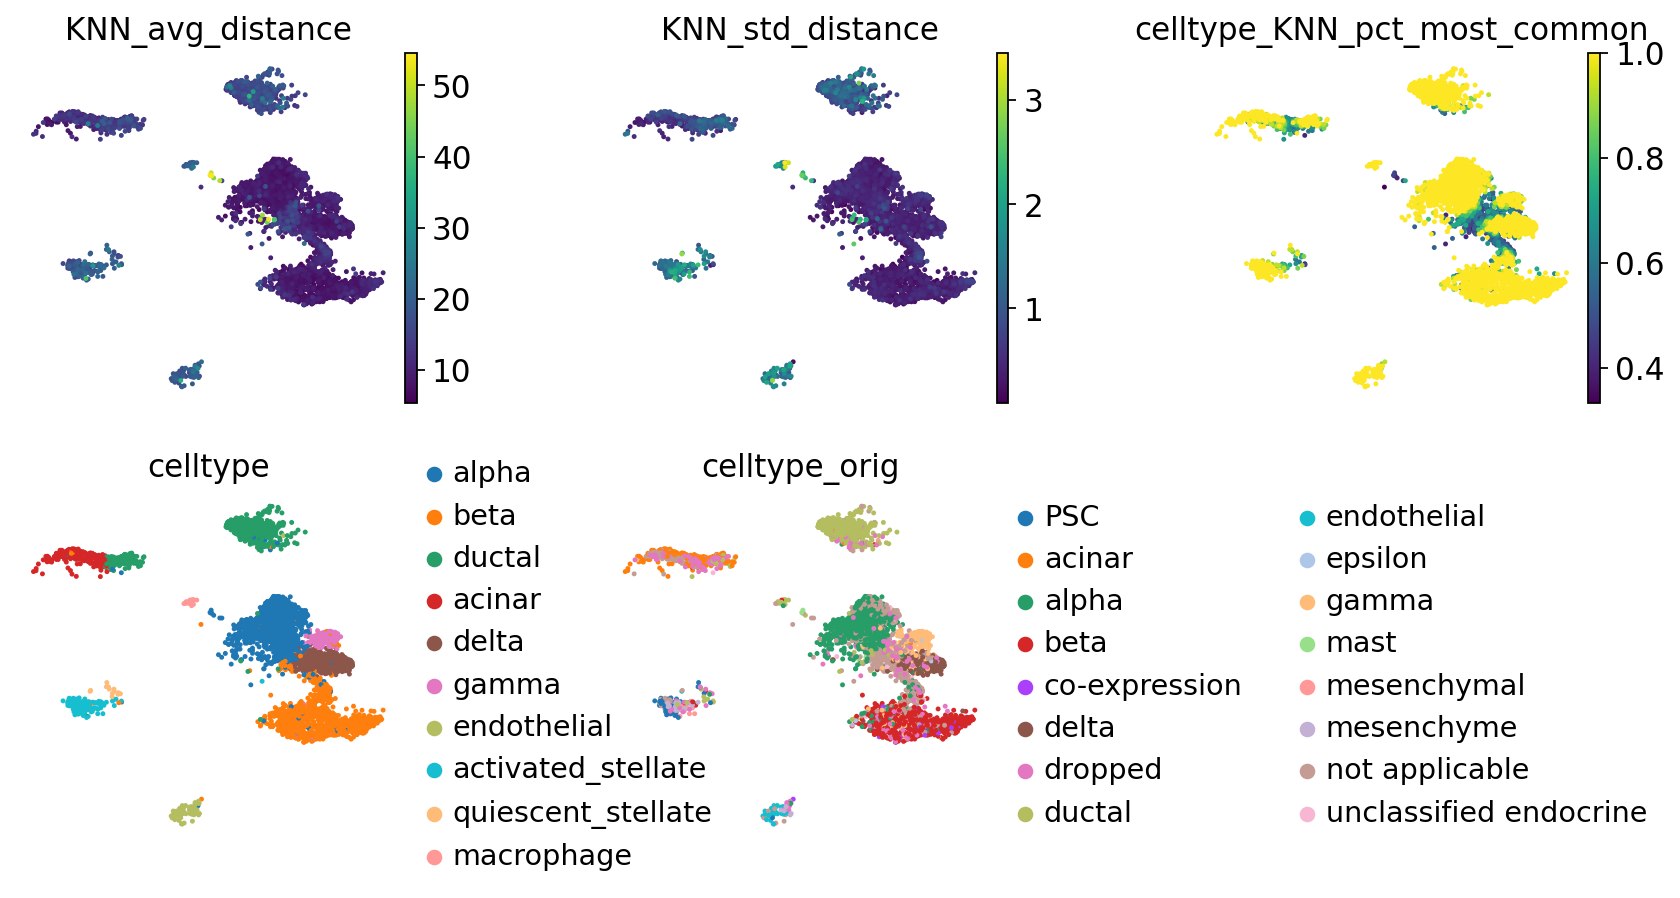

In [54]:
sc.pl.umap(
    adata_query, 
    color=['KNN_avg_distance','KNN_std_distance','celltype_KNN_pct_most_common', 'celltype', 'celltype_orig'], wspace=0.4, ncols=3)

#### just the adata_query cells that map to acinar cellypes

<AxesSubplot: >

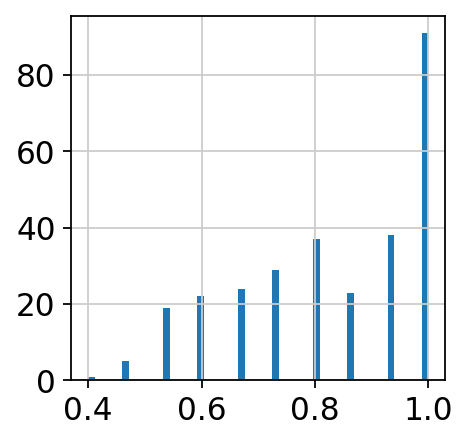

In [55]:
## here is the distribution of the  pct most common cell type for the query cells mapped to the acinar cellype
adata_query[adata_query.obs['celltype']=='acinar',:].obs['celltype_KNN_pct_most_common'].hist(bins=50)

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


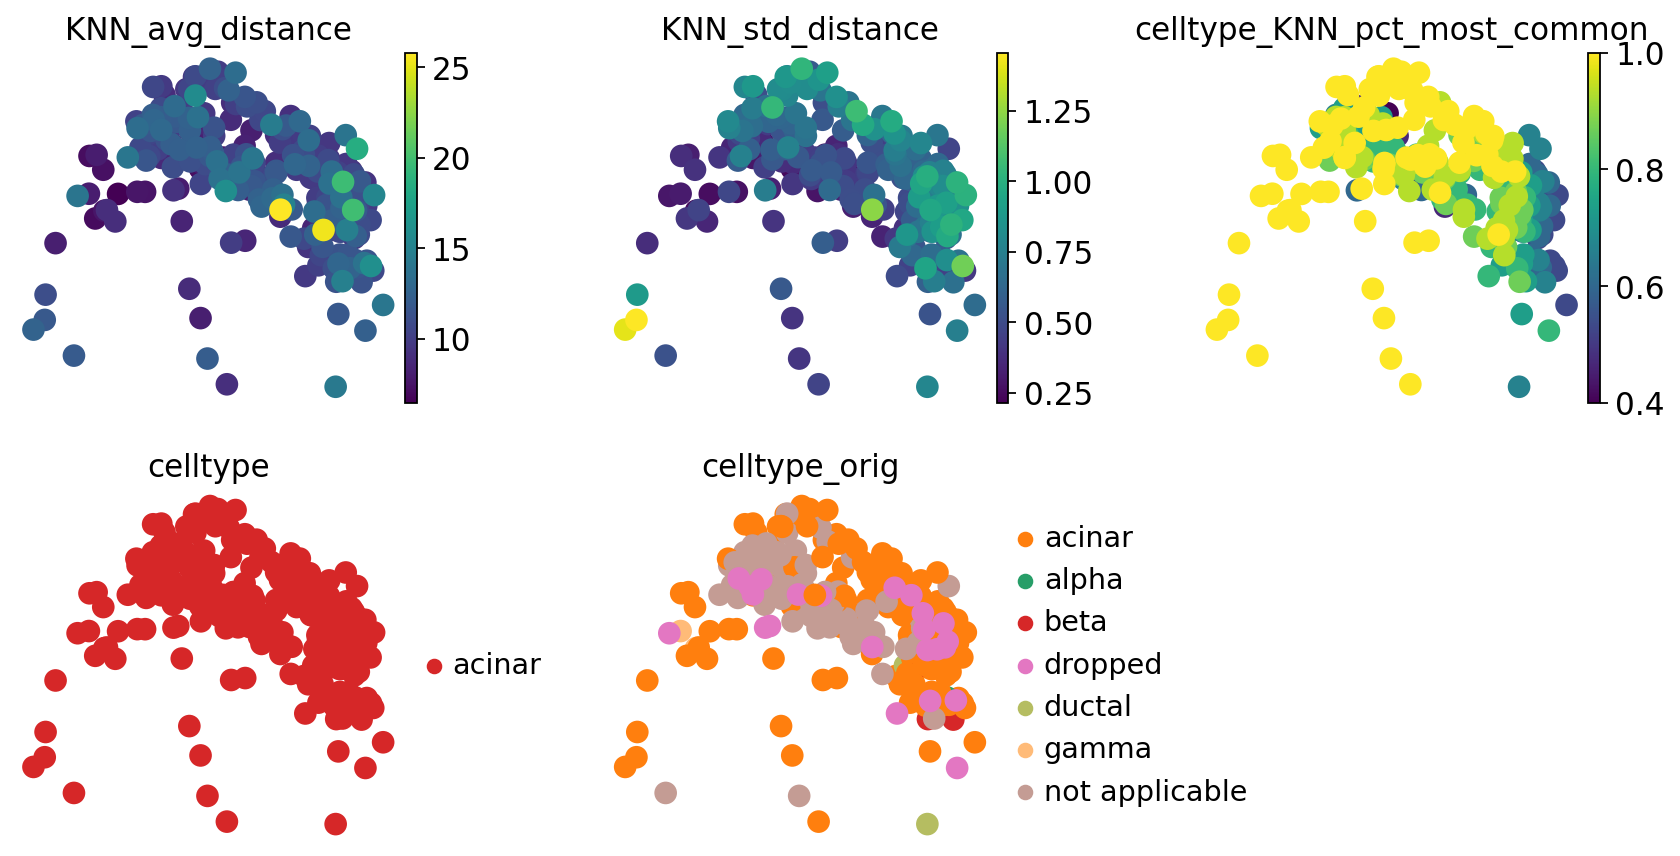

In [56]:
sc.pl.umap(
    adata_query[adata_query.obs['celltype']=='acinar',:], 
    color=['KNN_avg_distance','KNN_std_distance','celltype_KNN_pct_most_common', 'celltype', 'celltype_orig'], wspace=0.4, ncols=3)

#### the adata_query cells that mapped to the gamma cell type in the reference data set

<AxesSubplot: >

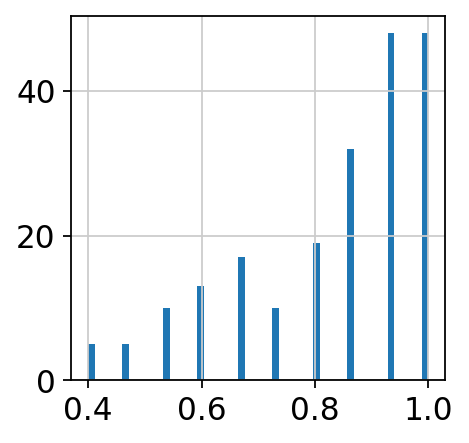

In [57]:
## here is the distribution of the  pct most common cell type for the query cells mapped to the gamma cellype
adata_query[adata_query.obs['celltype']=='gamma',:].obs['celltype_KNN_pct_most_common'].hist(bins=50)

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


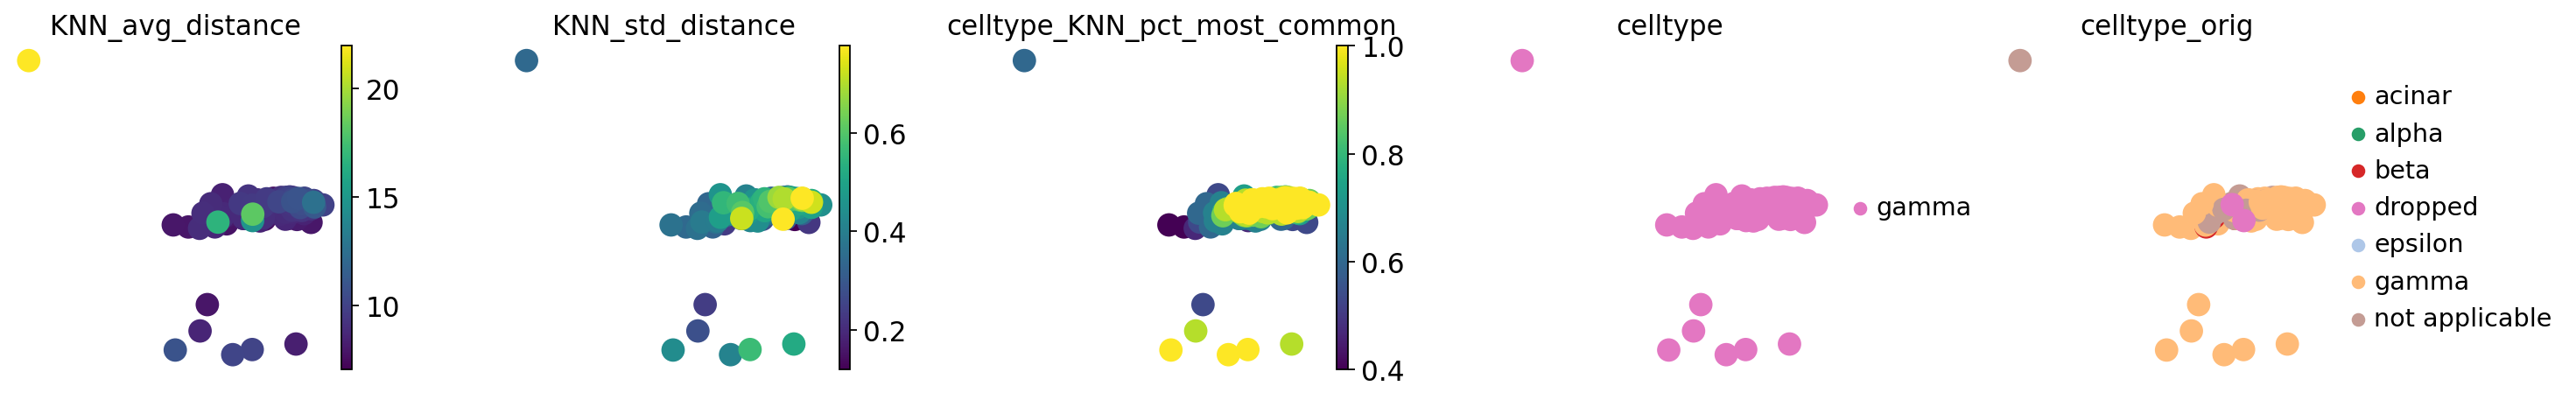

In [58]:
sc.pl.umap(
    adata_query[adata_query.obs['celltype']=='gamma',:], 
    color=['KNN_avg_distance','KNN_std_distance','celltype_KNN_pct_most_common', 'celltype', 'celltype_orig'], wspace=0.4, ncols=5)

* all these poorly mapping cells had a low pct most common cell type and many came from multipe celltype_orig labels

#### All cell types

Let us now move on to look at all cell types.

In [59]:
pd.crosstab(adata_query.obs.celltype, adata_query.obs.celltype_orig)

celltype_orig       PSC  acinar  alpha  beta  co-expression  delta  dropped  \
celltype                                                                      
alpha                 0       0   1814     3              3      1       37   
beta                  1       1     54   805             36     10       41   
ductal                0     242      6     6              0      0       40   
acinar                0     165      2     3              0      0       23   
delta                 0       0      6     3              0    305       12   
gamma                 0       1      1     5              0      0        2   
endothelial           1       0      2     0              0      0        7   
activated_stellate   48       1      1     2              0      0       11   
quiescent_stellate    4       0      1     1              0      0        5   
macrophage            0       0      1     1              0      0        0   

celltype_orig       ductal  endothelial  epsilon  gamma  mast  mesenchymal  \
celltype                                                                     
alpha                   12            0        3     19     7            0   
beta                     4            0        0     39     0            0   
ductal                 686            0        0      0     0            2   
acinar                   3            0        0      3     0            0   
delta                    2            0        6     73     0            0   
gamma                    0            0        1    182     0            0   
endothelial              0           36        0      0     0            0   
activated_stellate       6            0        0      0     0           78   
quiescent_stellate       2            1        0      0     0            0   
macrophage              12            0        0      0     0            0   

celltype_orig       mesenchyme  not applicable  unclassified endocrine  
celltype                                                                
alpha                        0             309                      10  
beta                         1             521                      24  
ductal                       0              97                       0  
acinar                       0              90                       0  
delta                        0              96                       7  
gamma                        0              15                       0  
endothelial                  6               7                       0  
activated_stellate          20              17                       0  
quiescent_stellate           0               1                       0  
macrophage                   0               1                       0

/tmp/ipykernel_1731556/1507883320.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.pcolor(norm_df)


celltype_orig            PSC    acinar     alpha      beta  co-expression  \
celltype                                                                    
alpha               0.000000  0.000000  0.960805  0.003619       0.076923   
beta                0.018519  0.002439  0.028602  0.971049       0.923077   
ductal              0.000000  0.590244  0.003178  0.007238       0.000000   
acinar              0.000000  0.402439  0.001059  0.003619       0.000000   
delta               0.000000  0.000000  0.003178  0.003619       0.000000   
gamma               0.000000  0.002439  0.000530  0.006031       0.000000   
endothelial         0.018519  0.000000  0.001059  0.000000       0.000000   
activated_stellate  0.888889  0.002439  0.000530  0.002413       0.000000   
quiescent_stellate  0.074074  0.000000  0.000530  0.001206       0.000000   
macrophage          0.000000  0.000000  0.000530  0.001206       0.000000   

celltype_orig          delta   dropped    ductal  endothelial  epsilon  \
celltype                                                                 
alpha               0.003165  0.207865  0.016506     0.000000      0.3   
beta                0.031646  0.230337  0.005502     0.000000      0.0   
ductal              0.000000  0.224719  0.943604     0.000000      0.0   
acinar              0.000000  0.129213  0.004127     0.000000      0.0   
delta               0.965190  0.067416  0.002751     0.000000      0.6   
gamma               0.000000  0.011236  0.000000     0.000000      0.1   
endothelial         0.000000  0.039326  0.000000     0.972973      0.0   
activated_stellate  0.000000  0.061798  0.008253     0.000000      0.0   
quiescent_stellate  0.000000  0.028090  0.002751     0.027027      0.0   
macrophage          0.000000  0.000000  0.016506     0.000000      0.0   

celltype_orig          gamma  mast  mesenchymal  mesenchyme  not applicable  \
celltype                                                                      
alpha               0.060127   1.0        0.000    0.000000        0.267764   
beta                0.123418   0.0        0.000    0.037037        0.451473   
ductal              0.000000   0.0        0.025    0.000000        0.084055   
acinar              0.009494   0.0        0.000    0.000000        0.077990   
delta               0.231013   0.0        0.000    0.000000        0.083189   
gamma               0.575949   0.0        0.000    0.000000        0.012998   
endothelial         0.000000   0.0        0.000    0.222222        0.006066   
activated_stellate  0.000000   0.0        0.975    0.740741        0.014731   
quiescent_stellate  0.000000   0.0        0.000    0.000000        0.000867   
macrophage          0.000000   0.0        0.000    0.000000        0.000867   

celltype_orig       unclassified endocrine  
celltype                                    
alpha                             0.243902  
beta                              0.585366  
ductal                            0.000000  
acinar                            0.000000  
delta                             0.170732  
gamma                             0.000000  
endothelial                       0.000000  
activated_stellate                0.000000  
quiescent_stellate                0.000000  
macrophage                        0.000000

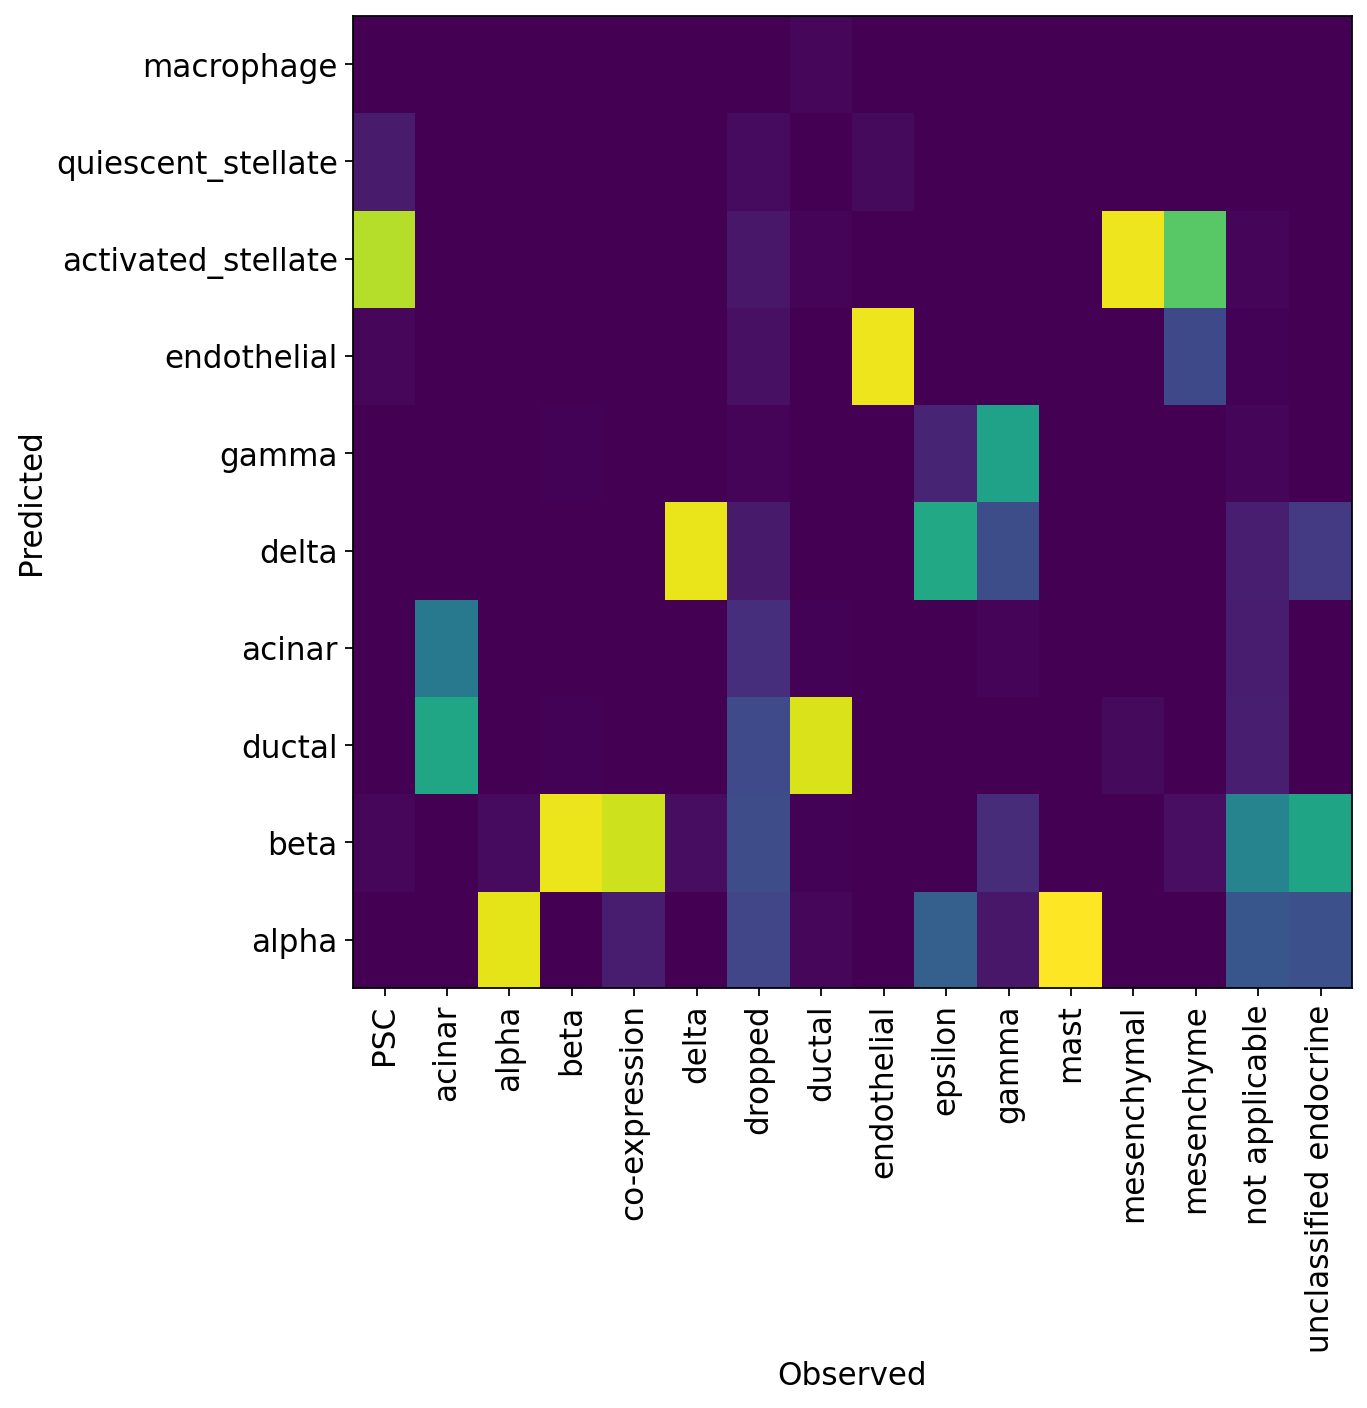

In [60]:
#df = adata_query.obs.groupby(["celltype", "celltype_orig"]).size().unstack(fill_value=0)
df=pd.crosstab(adata_query.obs.celltype, adata_query.obs.celltype_orig)
norm_df = df / df.sum(axis=0)

plt.figure(figsize=(8, 8))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("Observed")
plt.ylabel("Predicted")
norm_df

/tmp/ipykernel_1731556/1813976450.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  _ = plt.pcolor(norm_df)


celltype_orig            PSC    acinar     alpha      beta  co-expression  \
celltype                                                                    
alpha               0.000000  0.000000  0.960805  0.003619       0.076923   
beta                0.018519  0.002439  0.028602  0.971049       0.923077   
ductal              0.000000  0.590244  0.003178  0.007238       0.000000   
acinar              0.000000  0.402439  0.001059  0.003619       0.000000   
delta               0.000000  0.000000  0.003178  0.003619       0.000000   
gamma               0.000000  0.002439  0.000530  0.006031       0.000000   
endothelial         0.018519  0.000000  0.001059  0.000000       0.000000   
activated_stellate  0.888889  0.002439  0.000530  0.002413       0.000000   
quiescent_stellate  0.074074  0.000000  0.000530  0.001206       0.000000   
macrophage          0.000000  0.000000  0.000530  0.001206       0.000000   

celltype_orig          delta   dropped    ductal  endothelial  epsilon  \
celltype                                                                 
alpha               0.003165  0.207865  0.016506     0.000000      0.3   
beta                0.031646  0.230337  0.005502     0.000000      0.0   
ductal              0.000000  0.224719  0.943604     0.000000      0.0   
acinar              0.000000  0.129213  0.004127     0.000000      0.0   
delta               0.965190  0.067416  0.002751     0.000000      0.6   
gamma               0.000000  0.011236  0.000000     0.000000      0.1   
endothelial         0.000000  0.039326  0.000000     0.972973      0.0   
activated_stellate  0.000000  0.061798  0.008253     0.000000      0.0   
quiescent_stellate  0.000000  0.028090  0.002751     0.027027      0.0   
macrophage          0.000000  0.000000  0.016506     0.000000      0.0   

celltype_orig          gamma  mast  mesenchymal  mesenchyme  not applicable  \
celltype                                                                      
alpha               0.060127   1.0        0.000    0.000000        0.267764   
beta                0.123418   0.0        0.000    0.037037        0.451473   
ductal              0.000000   0.0        0.025    0.000000        0.084055   
acinar              0.009494   0.0        0.000    0.000000        0.077990   
delta               0.231013   0.0        0.000    0.000000        0.083189   
gamma               0.575949   0.0        0.000    0.000000        0.012998   
endothelial         0.000000   0.0        0.000    0.222222        0.006066   
activated_stellate  0.000000   0.0        0.975    0.740741        0.014731   
quiescent_stellate  0.000000   0.0        0.000    0.000000        0.000867   
macrophage          0.000000   0.0        0.000    0.000000        0.000867   

celltype_orig       unclassified endocrine  
celltype                                    
alpha                             0.243902  
beta                              0.585366  
ductal                            0.000000  
acinar                            0.000000  
delta                             0.170732  
gamma                             0.000000  
endothelial                       0.000000  
activated_stellate                0.000000  
quiescent_stellate                0.000000  
macrophage                        0.000000

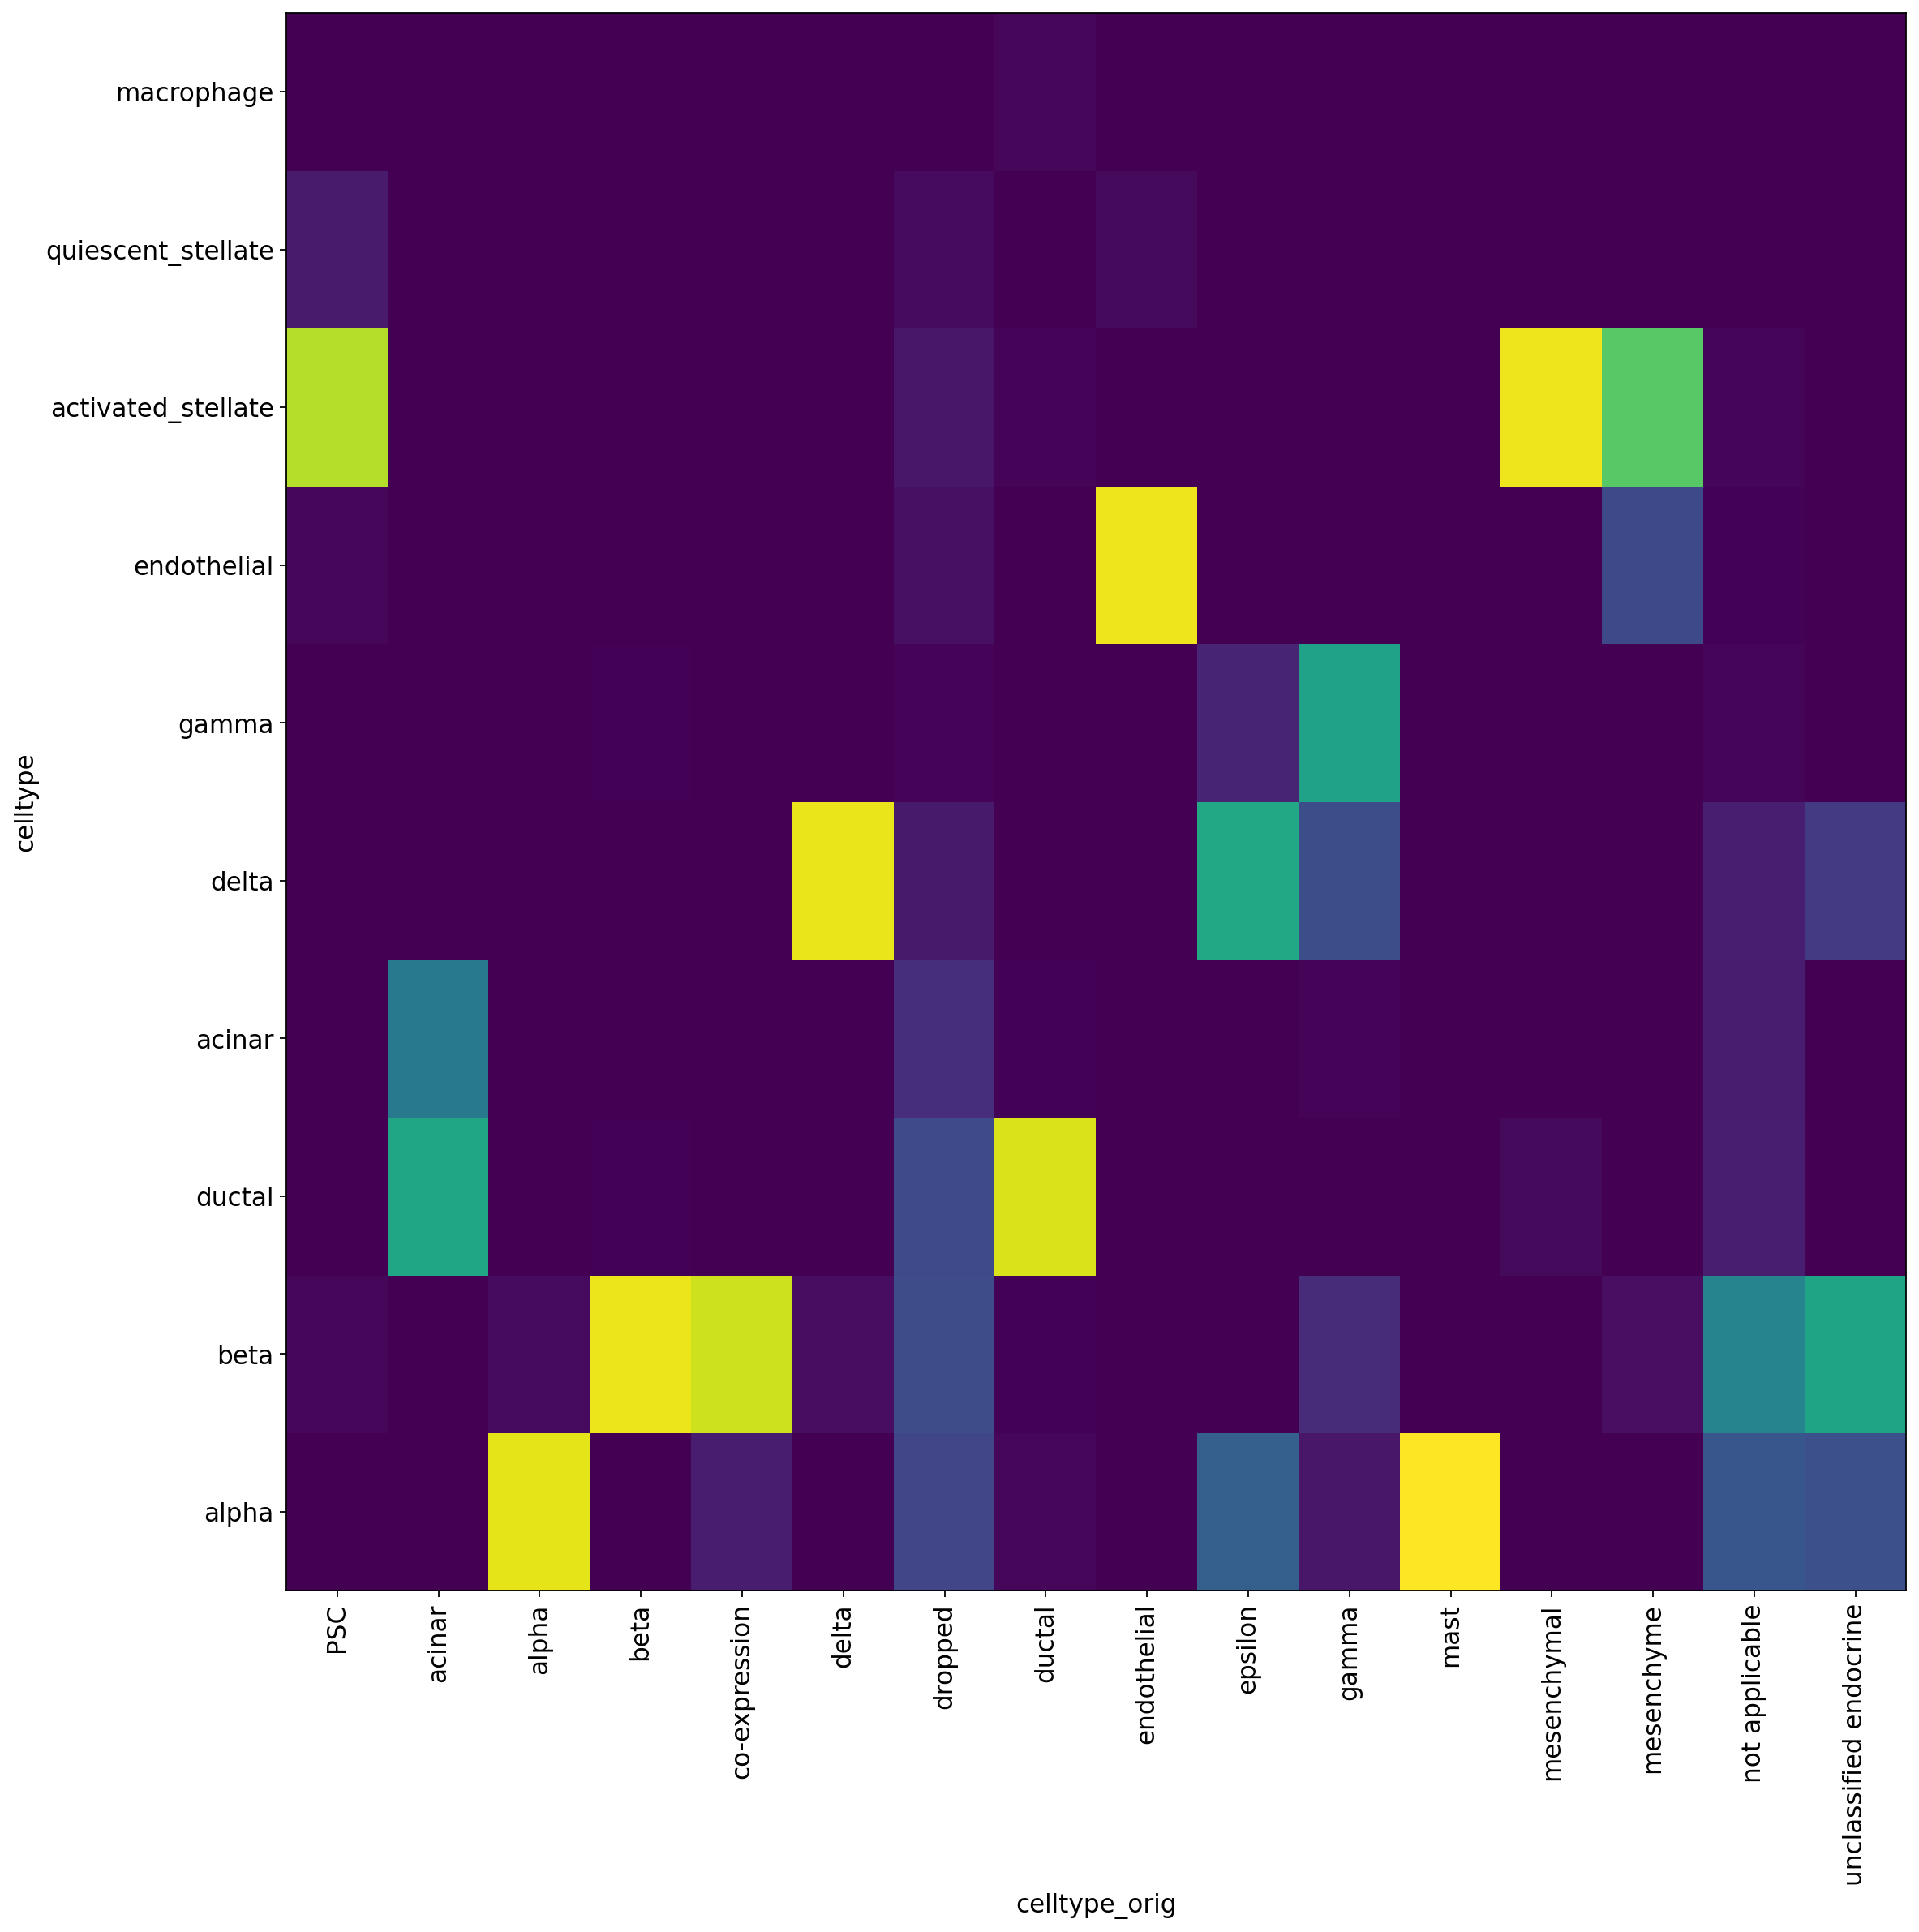

In [61]:
#df = adata_query.obs.groupby(["sample_ID", "predictions"]).size().unstack(fill_value=0)
#norm_df = df / df.sum(axis=0)
obs_key2='celltype'
batch_obs_key='celltype_orig'
df=pd.crosstab(adata_query.obs[obs_key2],adata_query.obs[batch_obs_key] )
norm_df=pd.crosstab(adata_query.obs[obs_key2],adata_query.obs[batch_obs_key], normalize='columns' )

plt.figure(figsize=(16, 16))
_ = plt.pcolor(norm_df)
_ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
_ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xlabel("celltype_orig")
plt.ylabel("celltype")

norm_df

We observe that PSC ([pancreatic stellate cells](https://en.wikipedia.org/wiki/Pancreatic_stellate_cell)) cells are in fact just inconsistently annotated and correctly mapped on 'activated_stellate' cells.

Also, it's nice to see that 'mesenchyme' and 'mesenchymal' cells both map onto the same category. However, that category is again 'activated_stellate' and likely incorrect.

### Visualizing distributions across batches

Often, batches correspond to experiments that one wants to compare. Scanpy offers to convenient visualization possibilities for this.

1. a density plot
2. a partial visualization of a subset of categories/groups in an emnbedding

#### Density plot

In [62]:
sc.tl.embedding_density(adata_concat, groupby='batch')

computing density on 'umap'


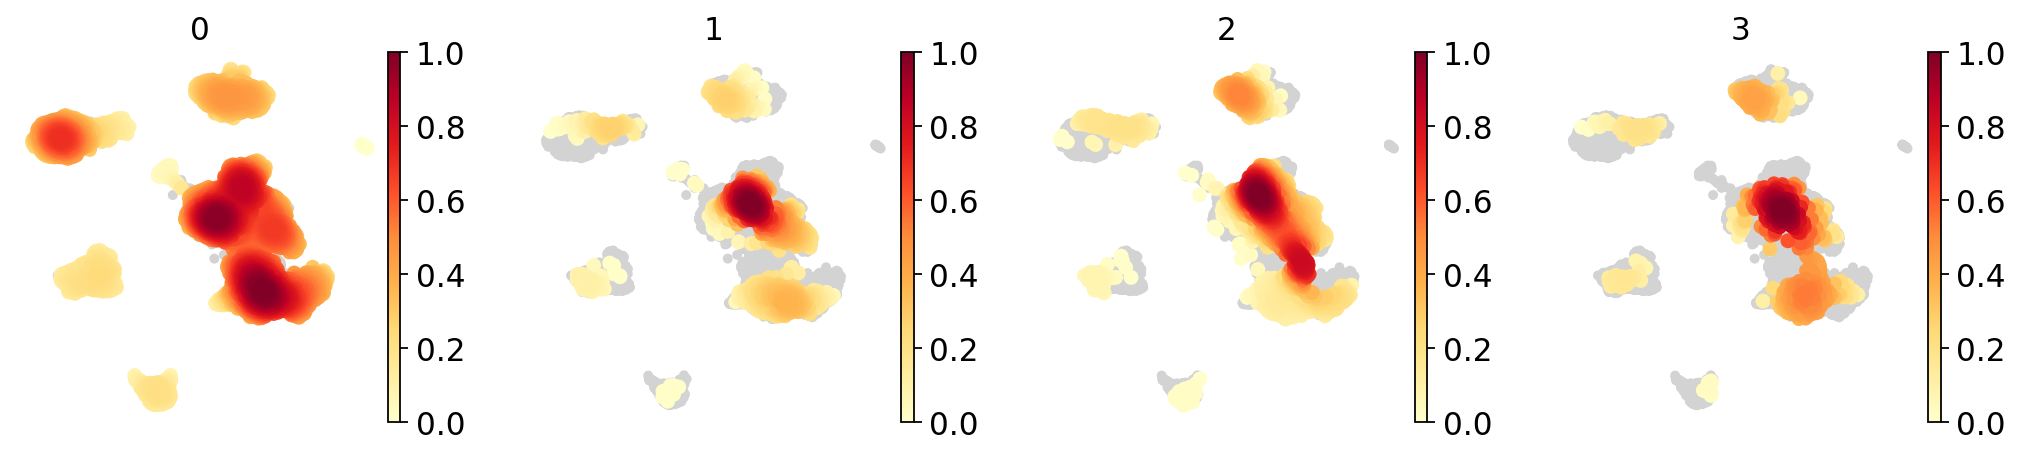

In [63]:
sc.pl.embedding_density(adata_concat, groupby='batch')

#### Partial visualizaton of a subset of groups in embedding

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


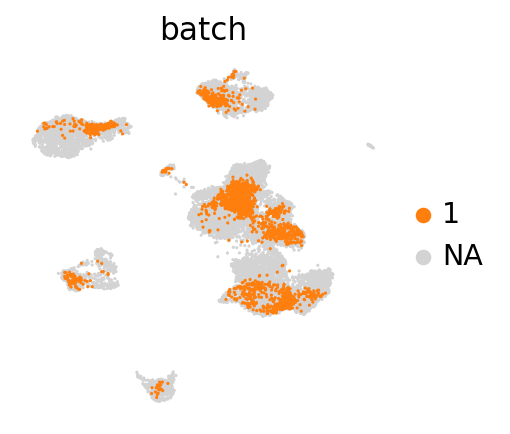

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


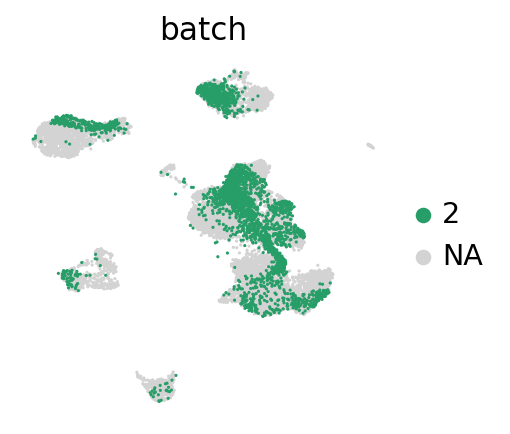

/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: In a future version of pandas all arguments of Categorical.replace except for the argument 'value' will be keyword-only.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)
/home/ubuntu/miniconda3/envs/py38_muon/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


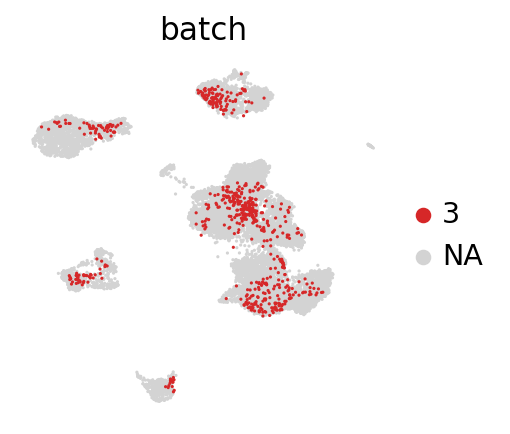

In [64]:
for batch in ['1', '2', '3']:
    sc.pl.umap(adata_concat, color='batch', groups=[batch])

# delete datasets so they dont mesh up youre git push to origin

In [65]:
%%bash
rm -rf data/*

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
